In [ ]:
!pip uninstall aerosandbox -y

In [ ]:
pip install -e .[full]

In [1]:
import aerosandbox as asb
import aerosandbox.numpy as np
import matplotlib.pyplot as plt
import numpy as np2

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       36

Total number of variables............................:        8
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.5747494e+04 0.00e+00 4.52e+06   0.0 0.00e+00    -  0.00e+00 0.00e+00 

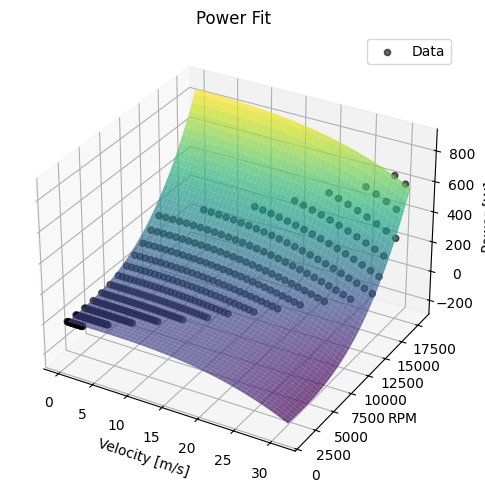

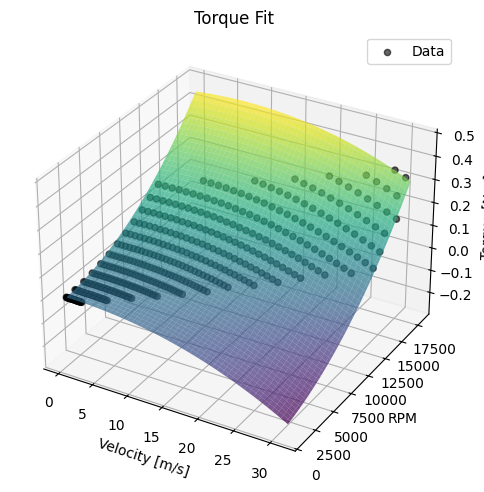

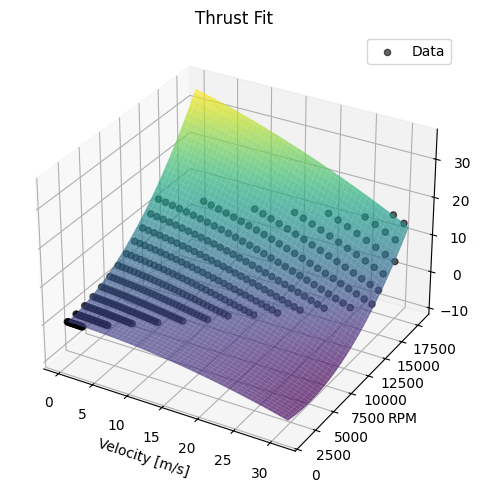

Predicted power:  123.987 W
Predicted torque: 0.117 Nm
Predicted thrust: 5.545 N
Prop efficiency: 0.620


In [1]:
## Surrogate model for APC data
import aerosandbox as asb
import aerosandbox.numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import r2_score
from scipy.interpolate import griddata

# --- Parser function for a single .dat file ---
def parse_propeller_dat_file(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()

    rpm_blocks = {}
    current_rpm = None
    data_started = False
    column_names = None
    data_lines = []

    for line in lines:
        match_rpm = re.search(r'PROP RPM\s*=\s*(\d+)', line)
        if match_rpm:
            if current_rpm is not None and data_lines:
                df = pd.DataFrame(data_lines, columns=column_names)
                rpm_blocks[current_rpm] = df
            current_rpm = int(match_rpm.group(1))
            data_started = False
            column_names = None
            data_lines = []
            continue

        if 'V' in line and 'mph' in line:
            continue
        elif column_names is None and line.strip().startswith("V"):
            column_names_raw = line.split()

            # Rename second occurrence of PWR, Torque, Thrust
            def rename_second_occurrence(names, target_names, suffixes):
                counts = {name: 0 for name in target_names}
                new_names = []
                for name in names:
                    if name in target_names:
                        counts[name] += 1
                        if counts[name] == 2:
                            idx = target_names.index(name)
                            new_names.append(name + suffixes[idx])
                        else:
                            new_names.append(name)
                    else:
                        new_names.append(name)
                return new_names

            target_names = ["PWR", "Torque", "Thrust"]
            suffixes = ["_W", "_Nm", "_N"]
            column_names = rename_second_occurrence(column_names_raw, target_names, suffixes)
            data_started = True
            continue

        if data_started:
            stripped = line.strip()
            if stripped == '':
                continue
            try:
                values = list(map(float, stripped.split()))
                if len(values) == len(column_names):
                    data_lines.append(values)
            except ValueError:
                continue

    if current_rpm is not None and data_lines:
        df = pd.DataFrame(data_lines, columns=column_names)
        rpm_blocks[current_rpm] = df

    return rpm_blocks


# --- Load and combine data ---
filepath = "PER3_9x45E.dat"
rpm_data = parse_propeller_dat_file(filepath)

# Concatenate data from all RPM blocks into one DataFrame
all_data = pd.concat(
    [df.assign(RPM=rpm) for rpm, df in rpm_data.items()],
    ignore_index=True
)

# --- Filter data: only keep points within desired bounds ---
# (before unit conversion, since file data is in lbf and mph)
all_data = all_data[
    (all_data["Thrust_N"] > 0) & (all_data["Thrust_N"] < 3.5 * 4.44822) &  # 3.5 lbf → N
    (all_data["V"] > 0) & (all_data["V"] < 70)                              # mph
].copy()

# --- Convert units ---
all_data["velocity"] = all_data["V"].astype(float) * 0.44704  # mph → m/s
all_data["rpm"]      = all_data["RPM"].astype(float)
all_data["power"]    = all_data["PWR_W"].astype(float)
all_data["torque"]   = all_data["Torque_Nm"].astype(float)
all_data["thrust"]   = all_data["Thrust_N"].astype(float)

# --- Compute Propulsive Efficiency (directly from data) ---
all_data["pe"] = np.where(
    (all_data["velocity"] > 0) & (all_data["power"] > 0),
    (all_data["thrust"] * all_data["velocity"]) / all_data["power"],
    0
)

# --- Fit surrogate models (power, torque, thrust only) ---
def model(x, p):
    v = x["velocity"]
    r = x["rpm"]
    return (
        p["c0"]
        + p["c_v"] * v
        + p["c_r"] * r
        + p["c_v2"] * v ** 2
        + p["c_r2"] * r ** 2
        + p["c_vr"] * v * r
        + p["c_v3"] * v ** 3
        + p["c_r3"] * r ** 3
    )

fitted_models = {}
for name in ["power", "torque", "thrust"]:
    fit = asb.FittedModel(
        model=model,
        x_data={
            "velocity": all_data["velocity"],
            "rpm":      all_data["rpm"],
        },
        y_data=all_data[name],
        parameter_guesses={
            "c0":  0,
            "c_v": 0,
            "c_r": 0,
            "c_v2": 0,
            "c_r2": 0,
            "c_vr": 0,
            "c_v3": 0,
            "c_r3": 0,
        },
    )
    fitted_models[name] = fit

# --- Compute predictions on the training set ---
X_dict = {
    "velocity": all_data["velocity"],
    "rpm":      all_data["rpm"],
}
for name in ["power", "torque", "thrust"]:
    all_data[f"pred_{name}"] = fitted_models[name](X_dict)

# --- Print R² for each fit ---
print("Fit quality:")
for name in ["power", "torque", "thrust"]:
    r2 = r2_score(all_data[name], all_data[f"pred_{name}"])
    print(f"  {name.capitalize():6s} R² = {r2:.4f}")

# --- Plot fitted Power model ---
v_plot = np.linspace(all_data["velocity"].min(), all_data["velocity"].max(), 100)
r_plot = np.linspace(all_data["rpm"].min(), all_data["rpm"].max(), 100)
V_plot, R_plot = np.meshgrid(v_plot, r_plot)

Power_fit = fitted_models["power"]({"velocity": V_plot.flatten(),"rpm": R_plot.flatten()}).reshape(V_plot.shape)
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(projection='3d')
ax.scatter(all_data["velocity"], all_data["rpm"], all_data["power"], color='k', alpha=0.6, label="Data")
ax.plot_surface(V_plot, R_plot, Power_fit, alpha=0.7, cmap="viridis", edgecolor="none", rcount=50, ccount=50)
ax.set_xlabel("Velocity [m/s]")
ax.set_ylabel("RPM")
ax.set_zlabel("Power [W]")
ax.set_title("Power Fit")
ax.legend()
plt.tight_layout()
plt.show()

# --- Plot fitted Torque model ---
Torque_fit = fitted_models["torque"]({"velocity": V_plot.flatten(),"rpm": R_plot.flatten()}).reshape(V_plot.shape)
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(projection='3d')
ax.scatter(all_data["velocity"], all_data["rpm"], all_data["torque"], color='k', alpha=0.6, label="Data")
ax.plot_surface(V_plot, R_plot, Torque_fit, alpha=0.7, cmap="viridis", edgecolor="none", rcount=50, ccount=50)
ax.set_xlabel("Velocity [m/s]")
ax.set_ylabel("RPM")
ax.set_zlabel("Torque [Nm]")
ax.set_title("Torque Fit")
ax.legend()
plt.tight_layout()
plt.show()

# --- Plot fitted Thrust model ---
Thrust_fit = fitted_models["thrust"]({"velocity": V_plot.flatten(),"rpm": R_plot.flatten()}).reshape(V_plot.shape)
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(projection='3d')
ax.scatter(all_data["velocity"], all_data["rpm"], all_data["thrust"], color='k', alpha=0.6, label="Data")
ax.plot_surface(V_plot, R_plot, Thrust_fit, alpha=0.7, cmap="viridis", edgecolor="none", rcount=50, ccount=50)
ax.set_xlabel("Velocity [m/s]")
ax.set_ylabel("RPM")
ax.set_zlabel("Thrust [N]")
ax.set_title("Thrust Fit")
ax.legend()
plt.tight_layout()
plt.show()

# --- Example usage: predict thrust, torque, power ---
v_ex   = 13.8582      # m/s
r_ex   = 10000  # rpm

pred_power = fitted_models["power"]({"velocity": v_ex, "rpm": r_ex})
print(f"Predicted power:  {pred_power:.3f} W")

pred_torque = fitted_models["torque"]({"velocity": v_ex, "rpm": r_ex})
print(f"Predicted torque: {pred_torque:.3f} Nm")

pred_thrust = fitted_models["thrust"]({"velocity": v_ex, "rpm": r_ex})
print(f"Predicted thrust: {pred_thrust:.3f} N")

p_e = (pred_thrust * v_ex) / pred_power
print(f"Prop efficiency: {p_e:.3f}")

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      805
Number of nonzeros in inequality constraint Jacobian.:      104
Number of nonzeros in Lagrangian Hessian.............:      412

Total number of variables............................:      124
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      116
Total number of inequality constraints...............:       64
        inequality constraints with only lower bounds:       30
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       34

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -6.9219825e+00 3.57e+02 1.12e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

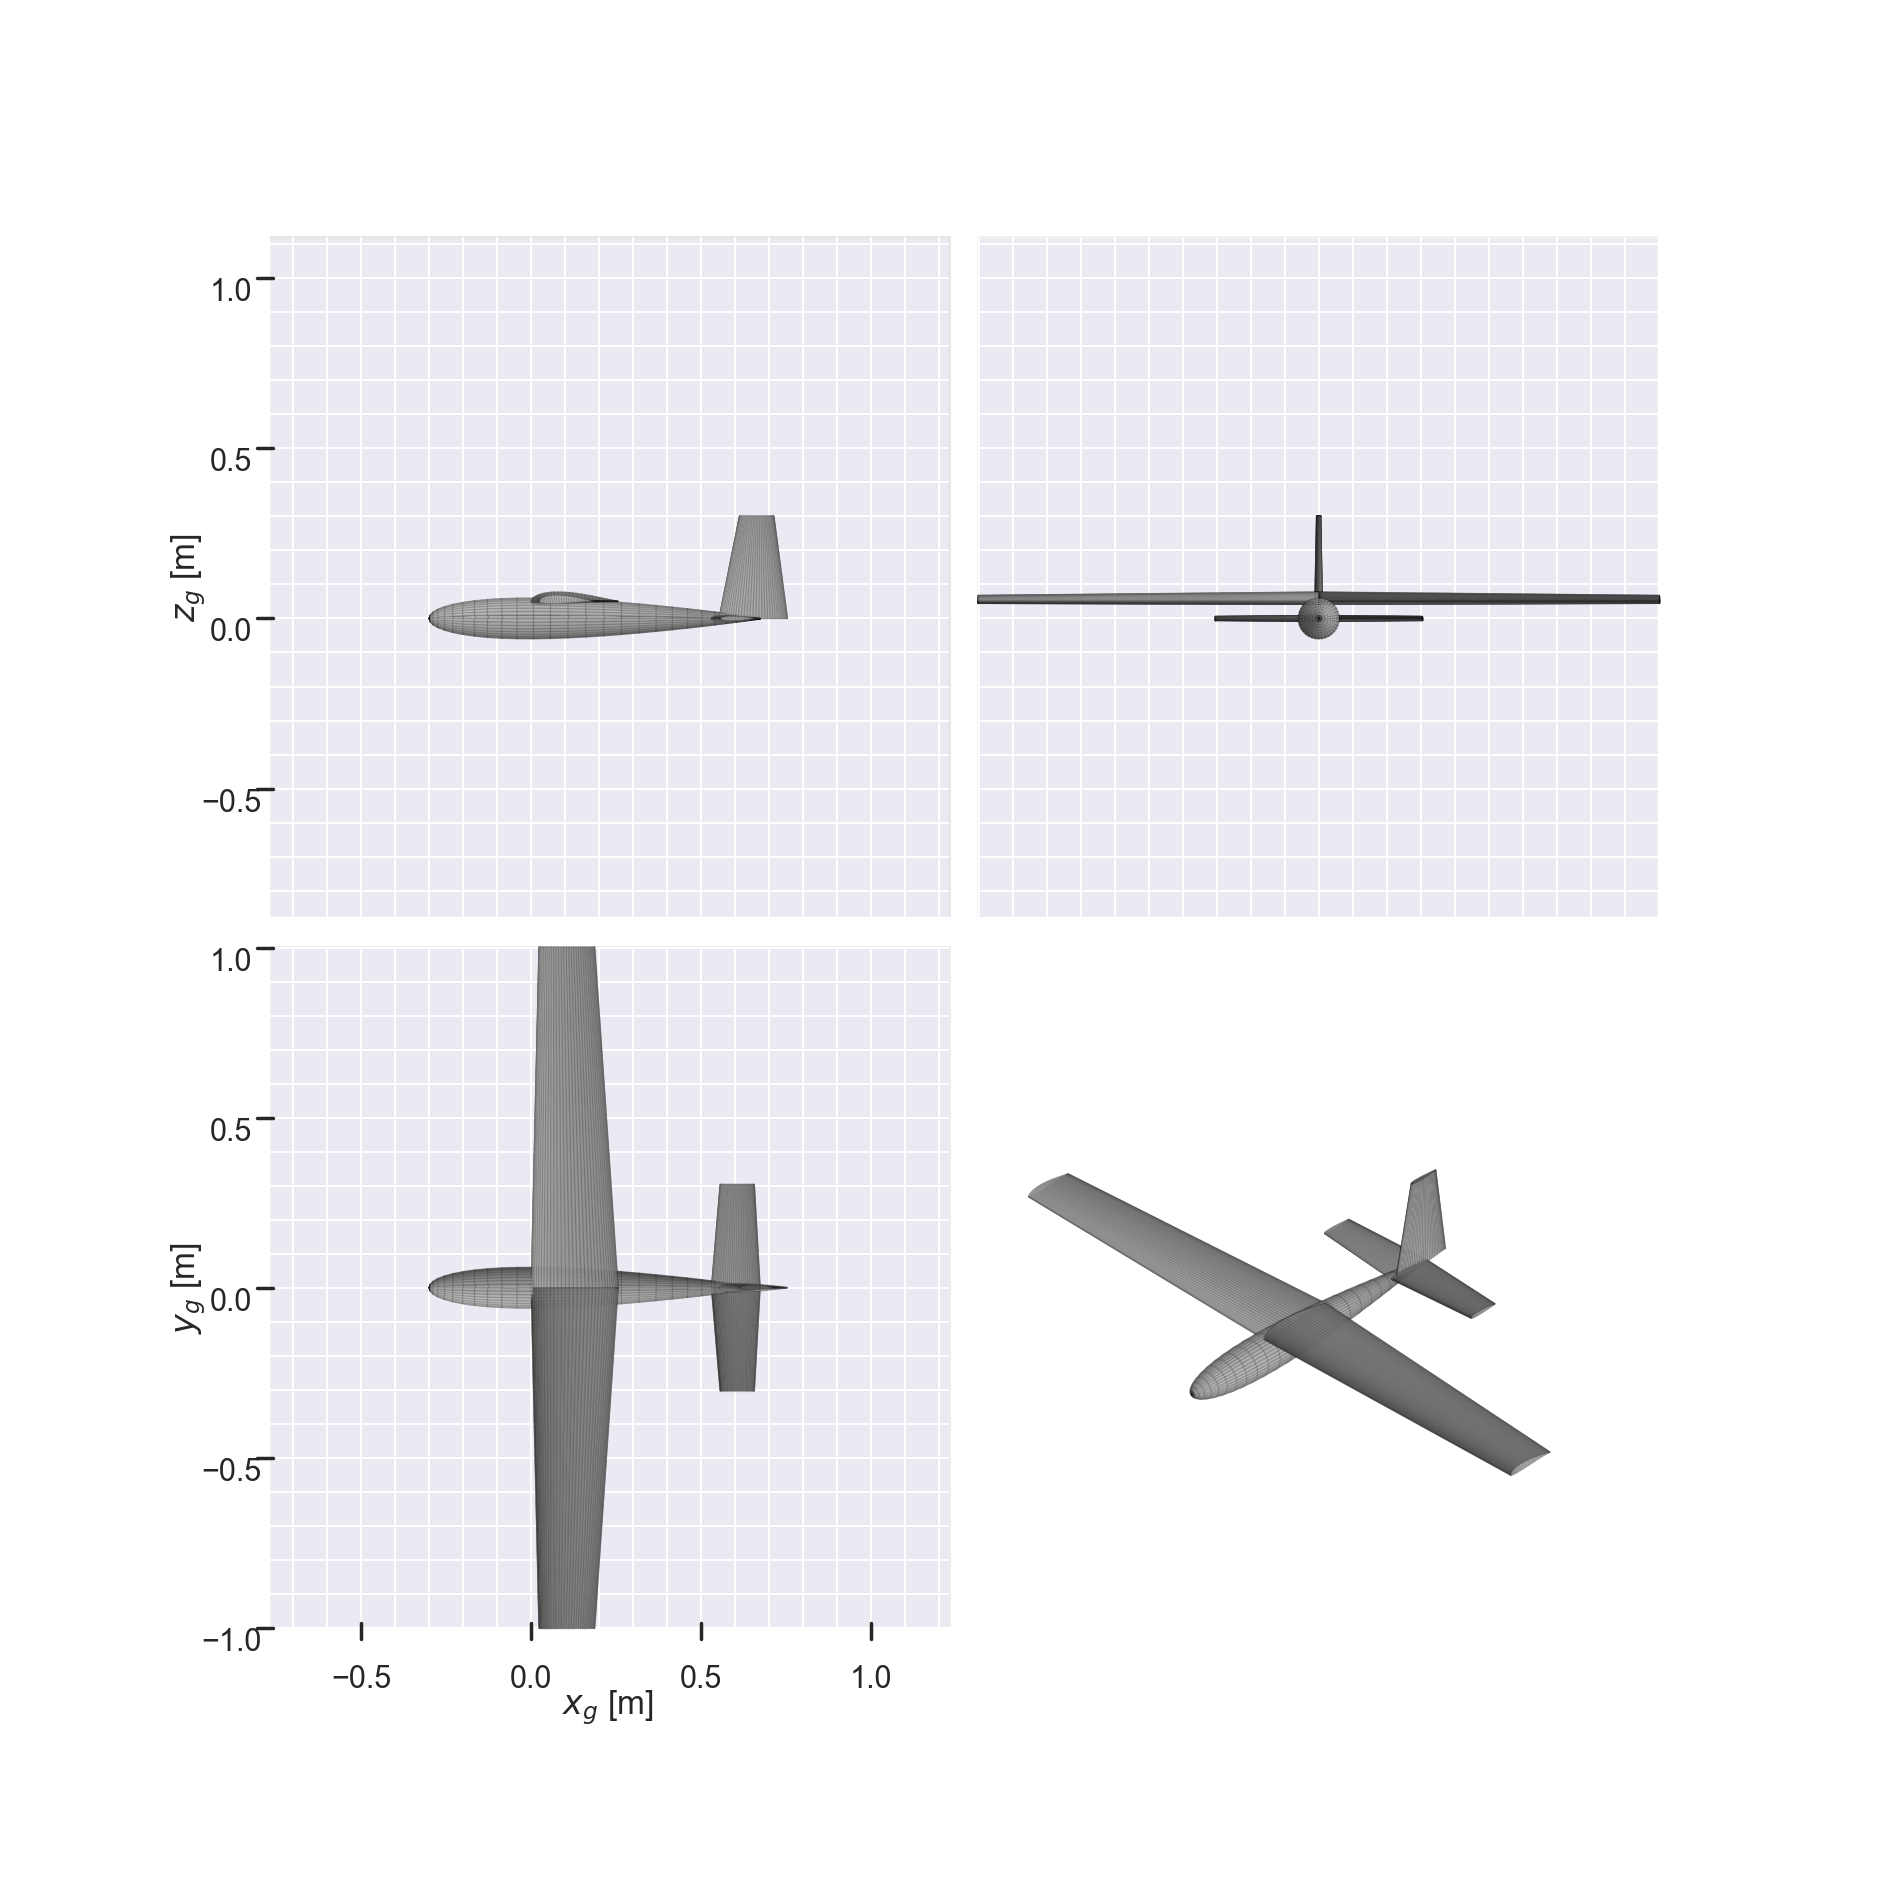


Wing Area: 0.41993608099262303
Aspect Ratio: 9.556429753602444
Taper Ratio: 0.6401290879499861
Twist: 0.0 deg

Tail Area: 0.07380805073170899
Tail Aspect Ratio: 5.0
Tail Taper Ratio: 0.7

Wingspan: 2.0032697419491736 m
Root Chord: 0.25562052605329866 m
Tip Chord: 0.16363013420379374 m

Horizontal Tail Span: 0.6074868341442018 m
Horizontal Tail Root Chord: 0.14293807862216512 m
Horizontal Tail Tip Chord: 0.10005665503551558 m
Tail Offset: 0.5300713092983318 m
Horizontal Tail Length from Wing: 0.5089635201489378 m

Vertical Tail Span: 0.3017504965984617 m
Vertical Tail Root Chord: 0.2011669977323078 m
Vertical Tail Tip Chord: 0.1005834988661539 m
Vertical Tail Length from Wing: 0.5543421292467107 m

Real Stall Speed: 7.465820994072523 m/s
Set Stall Speed: 7.839112043776149 m/s
Minimium Speed: 9.40693445253138 m/s
Cruise Speed: 12.40693445253138 m/s
Max Speed: 18.610401678797068 m/s

x_cg: 0.06422398423975344 m
x_np: 0.10682185637628872 m
SM: 0.1999999999974016

Cruise RPM: 7225.55766441

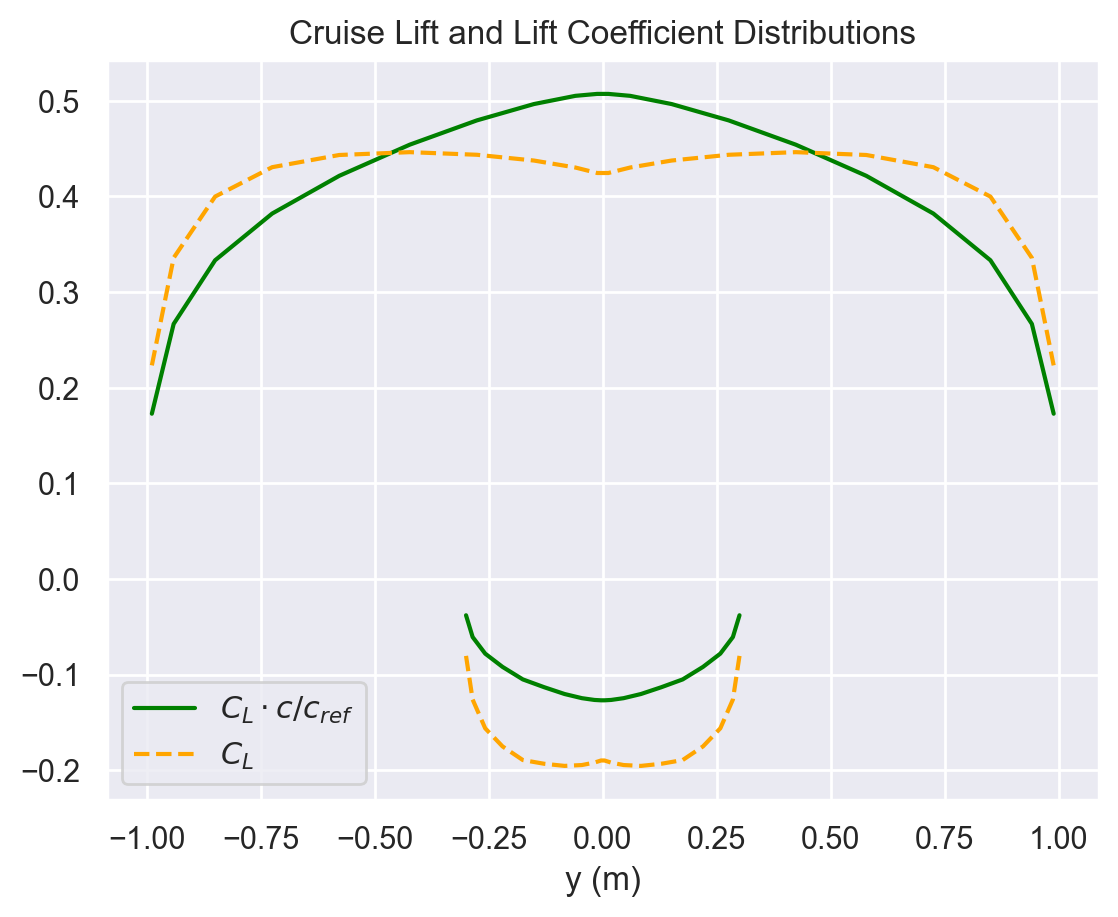

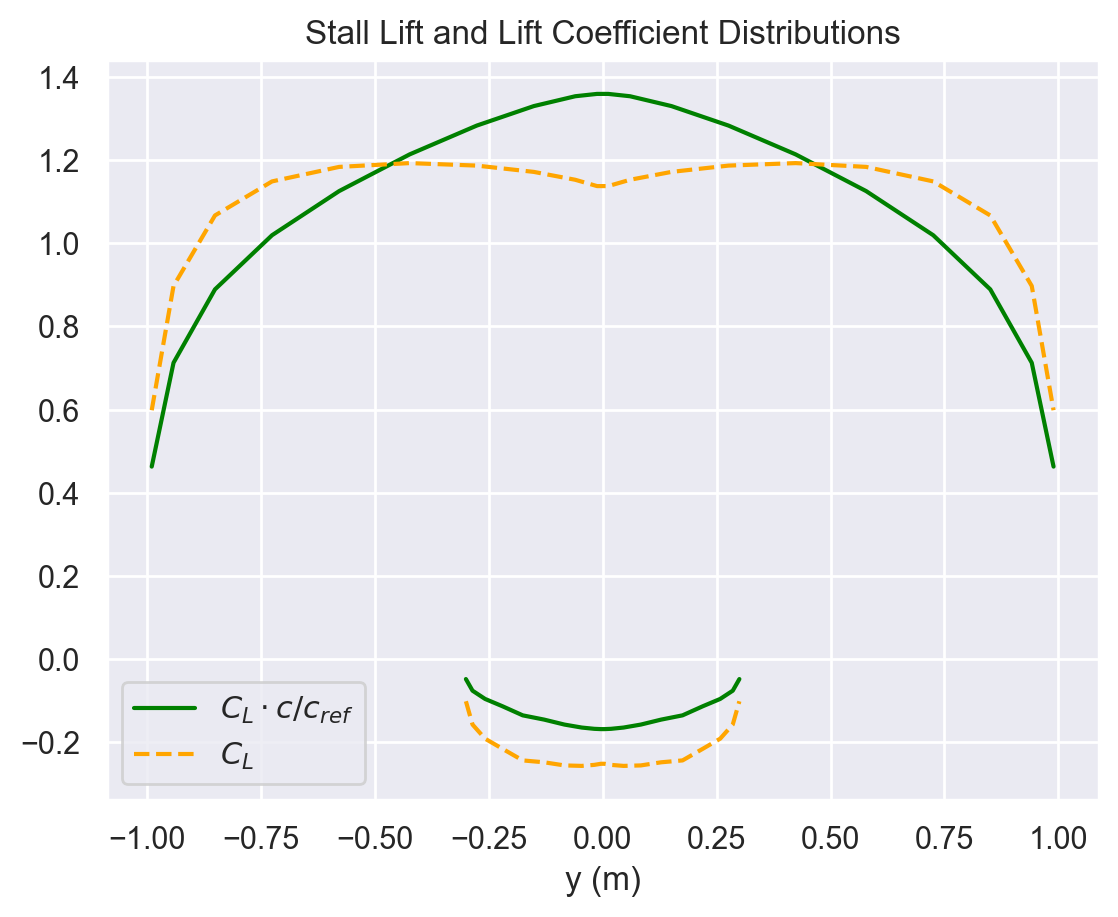

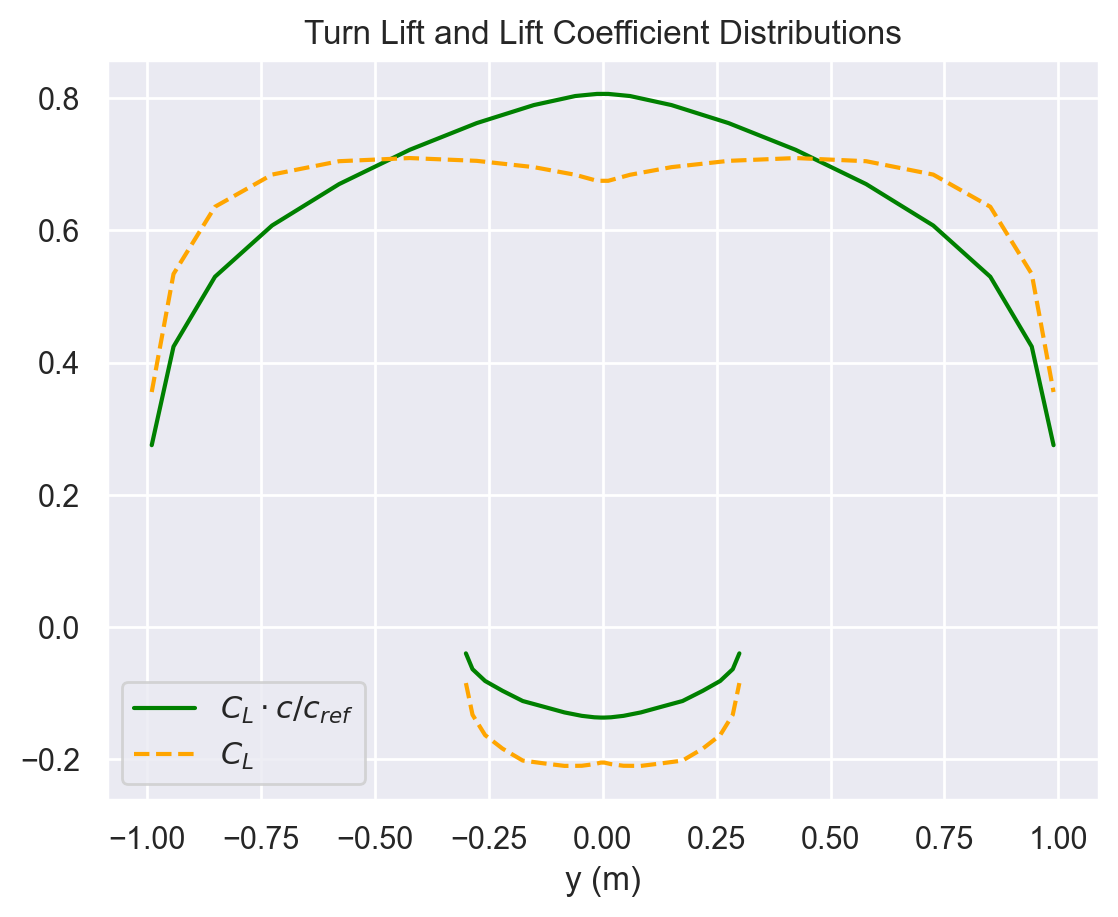

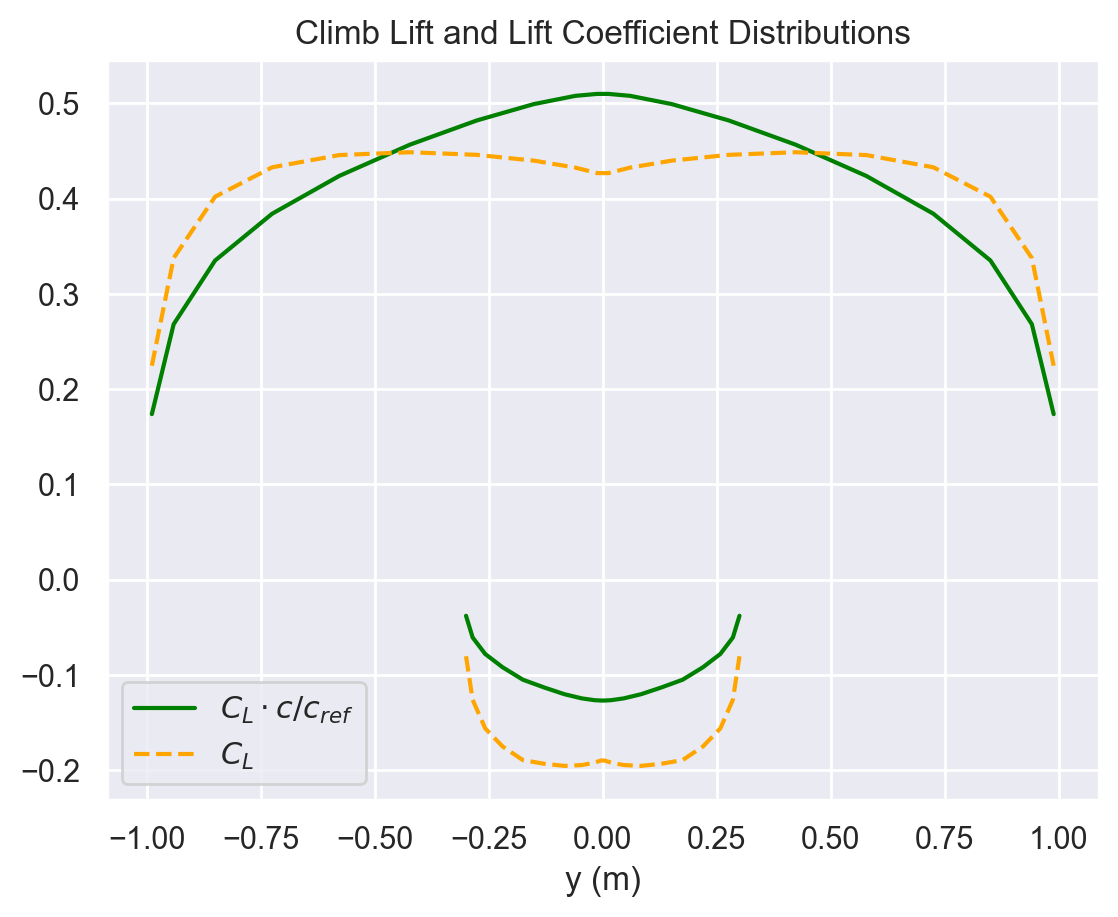

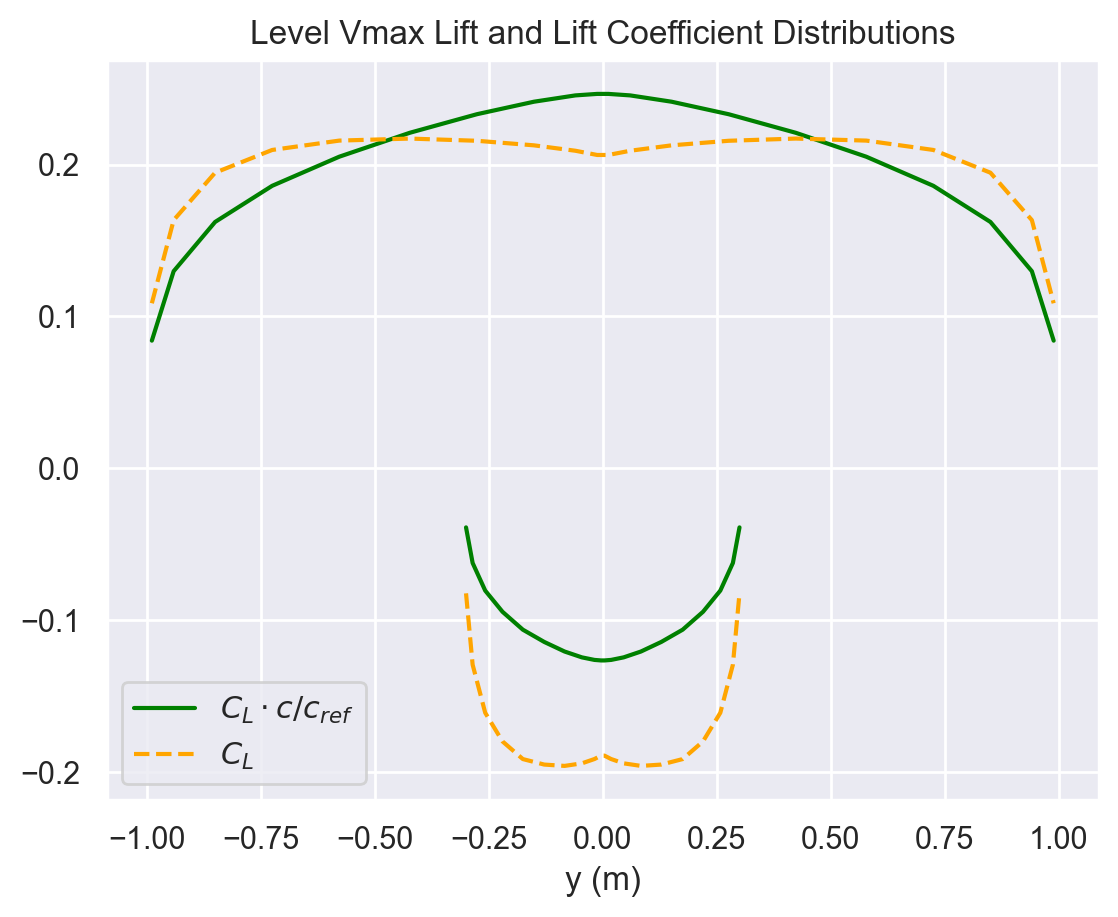

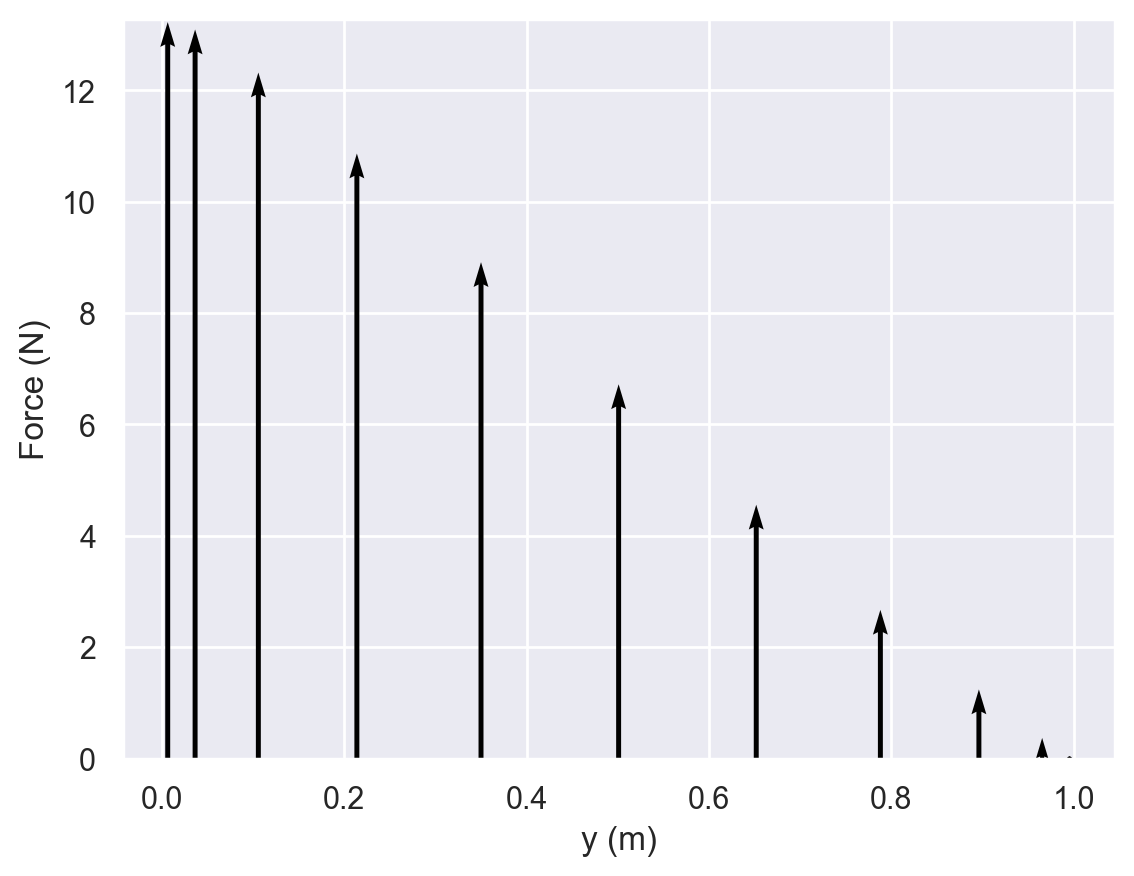

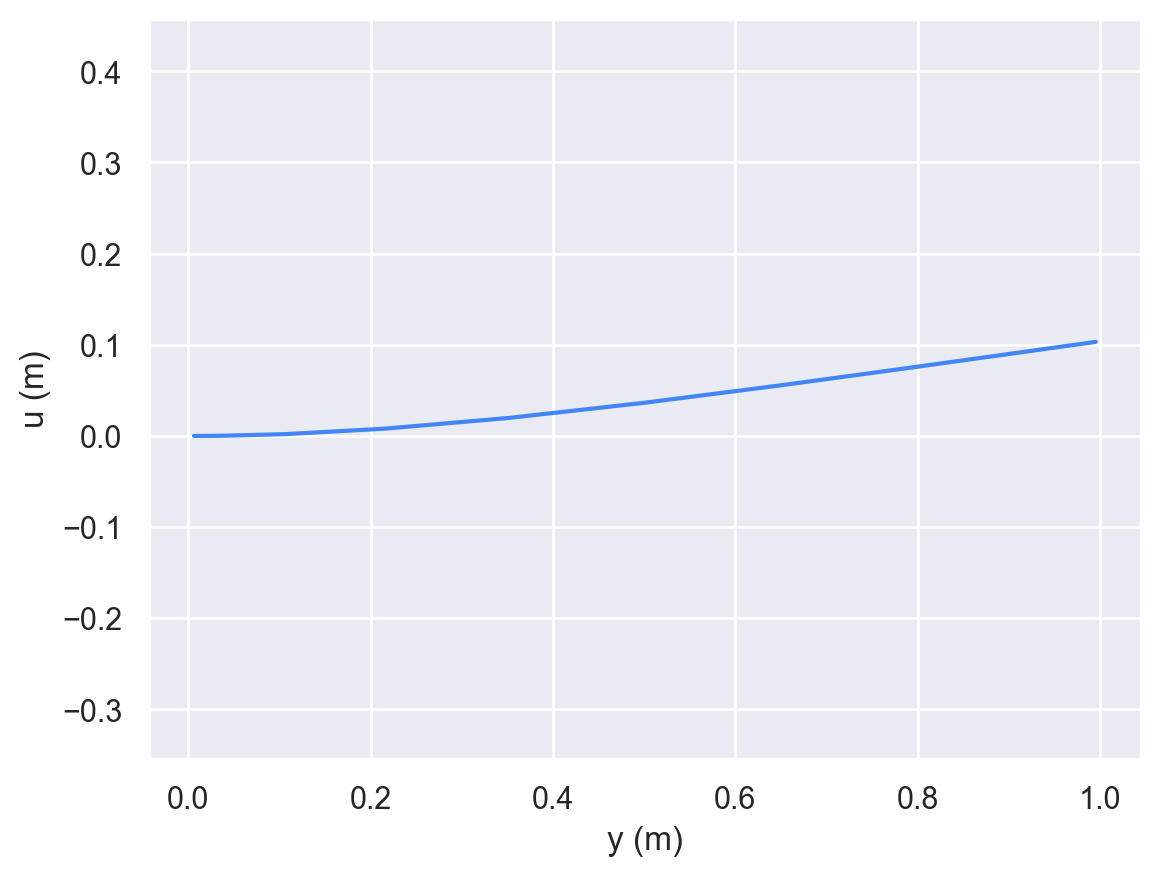

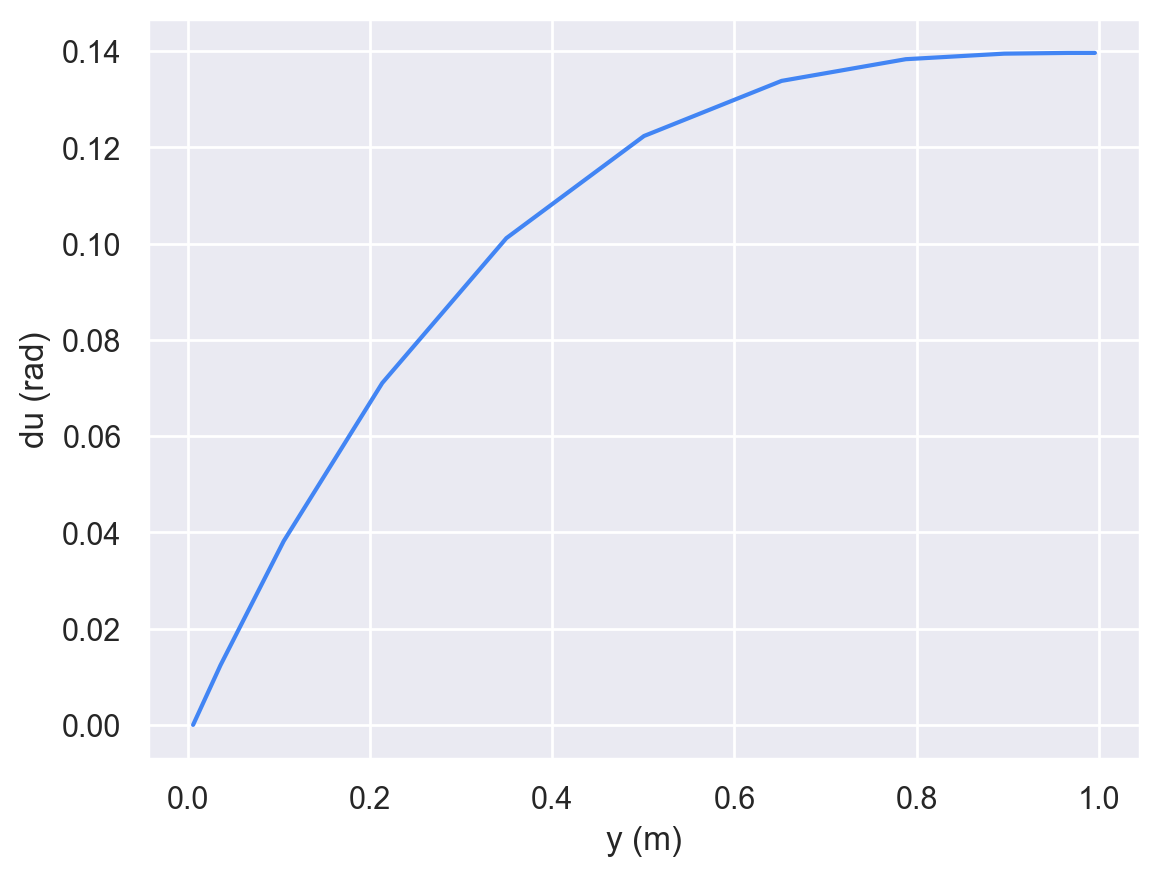

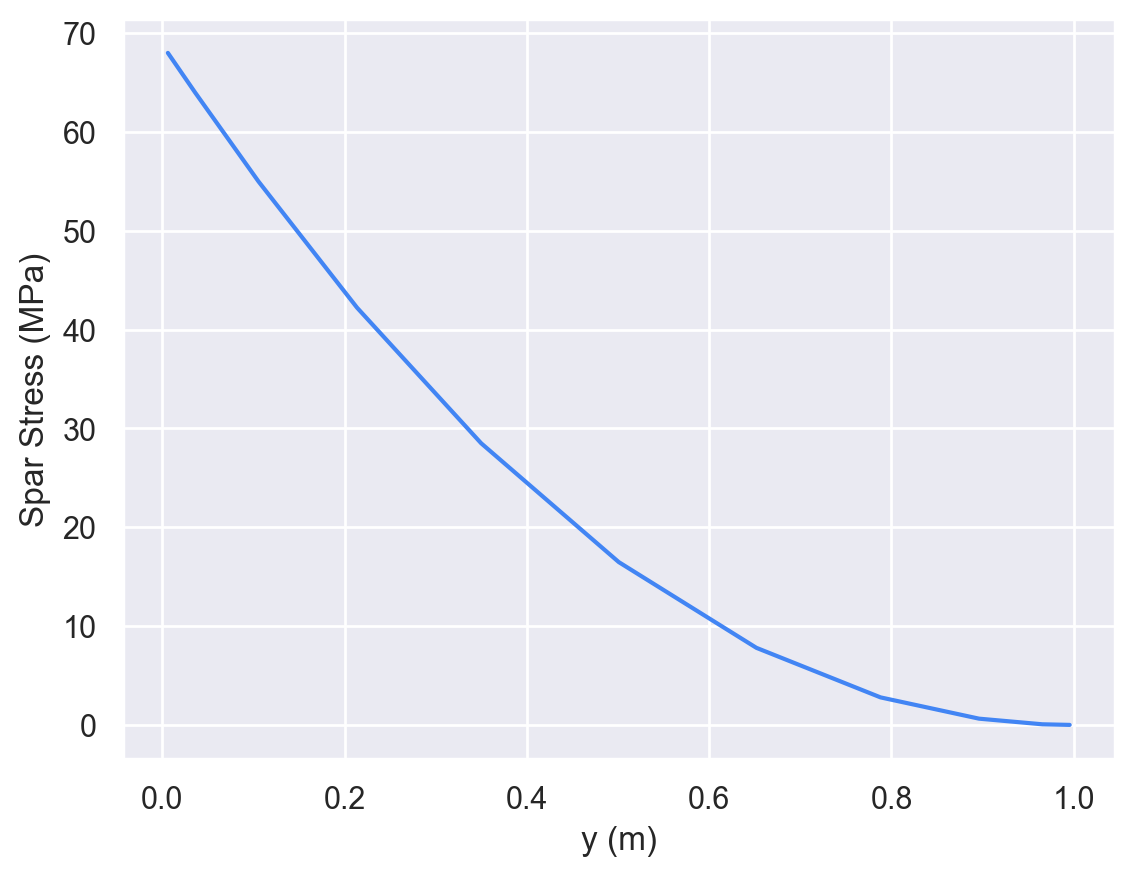

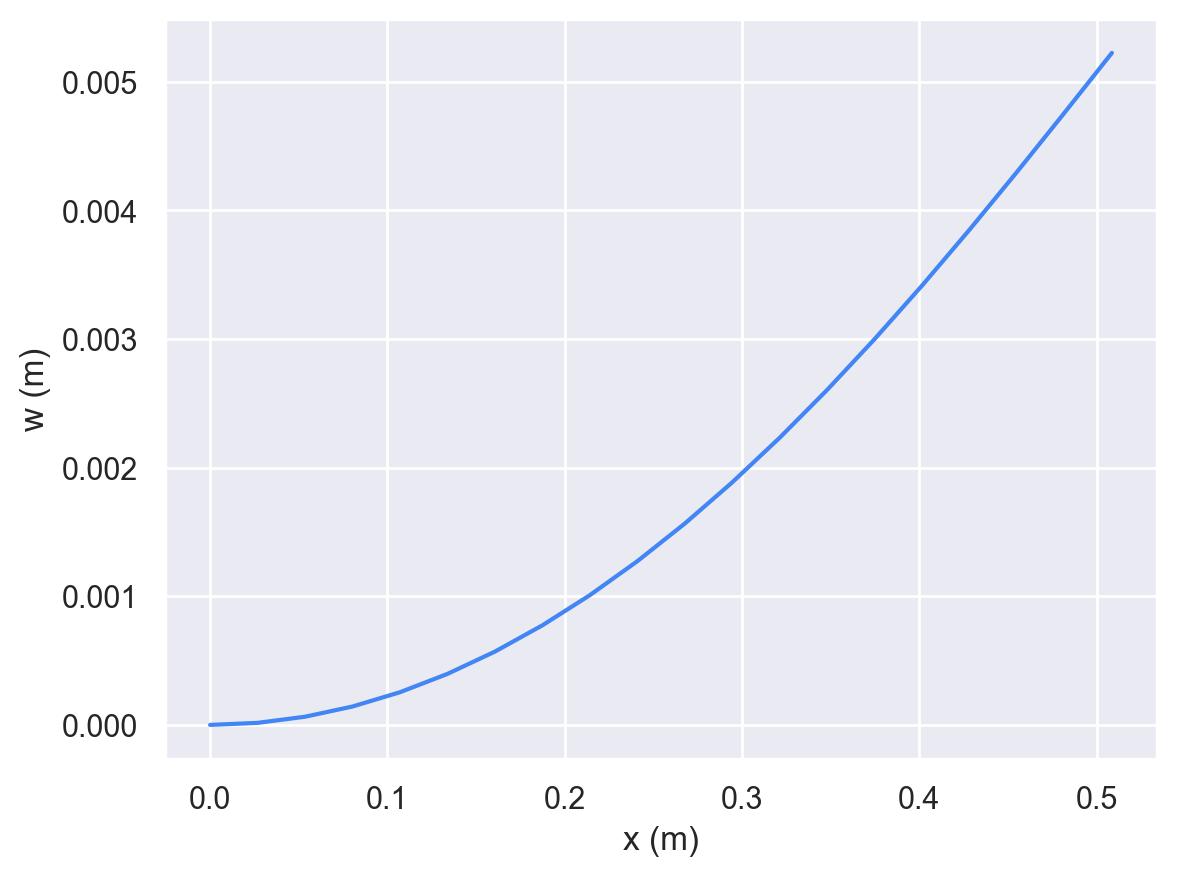

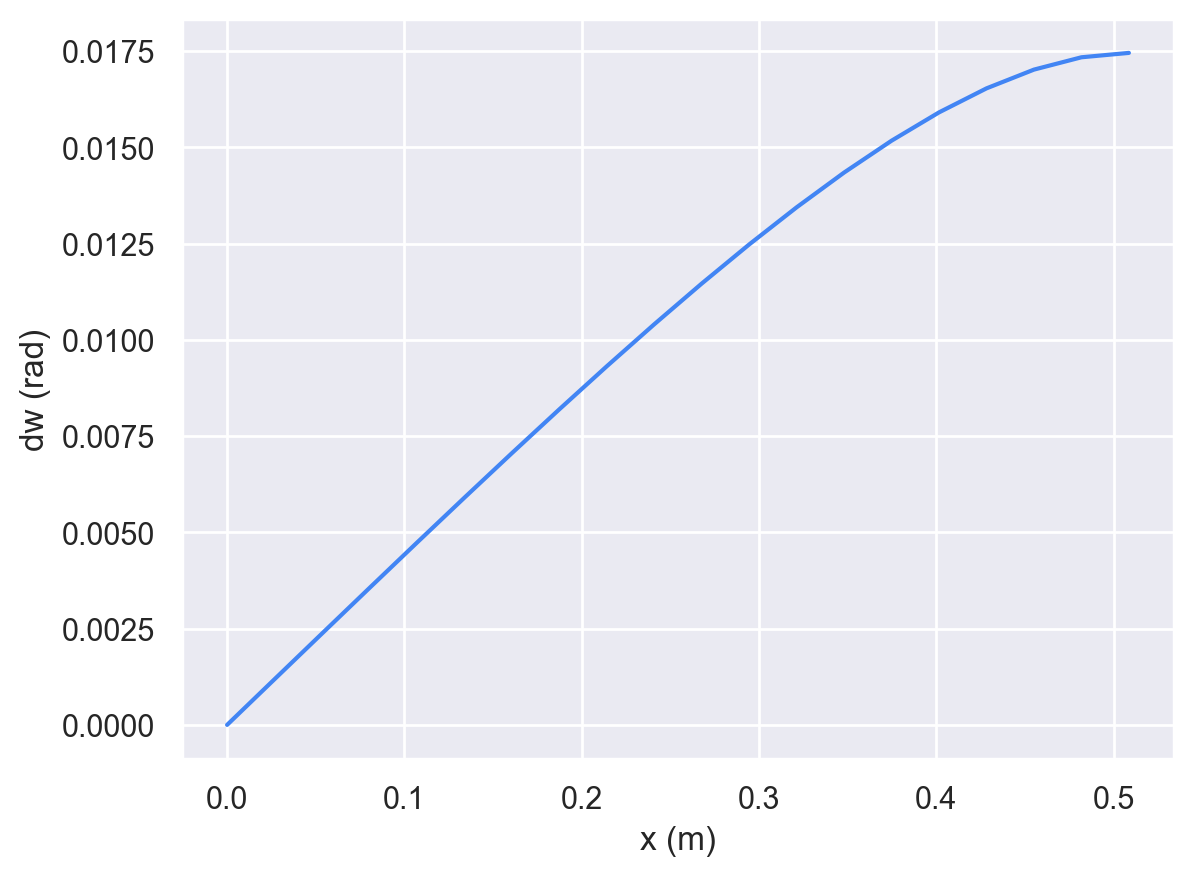

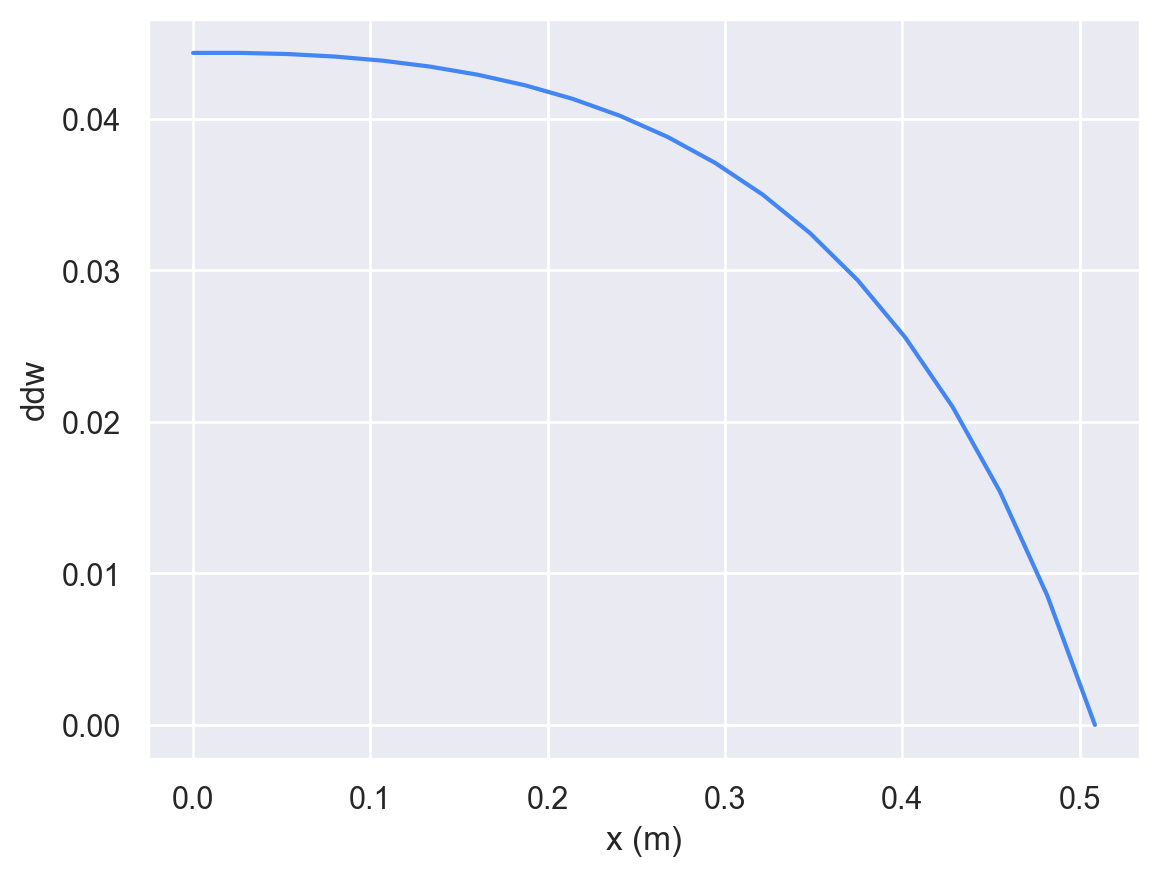

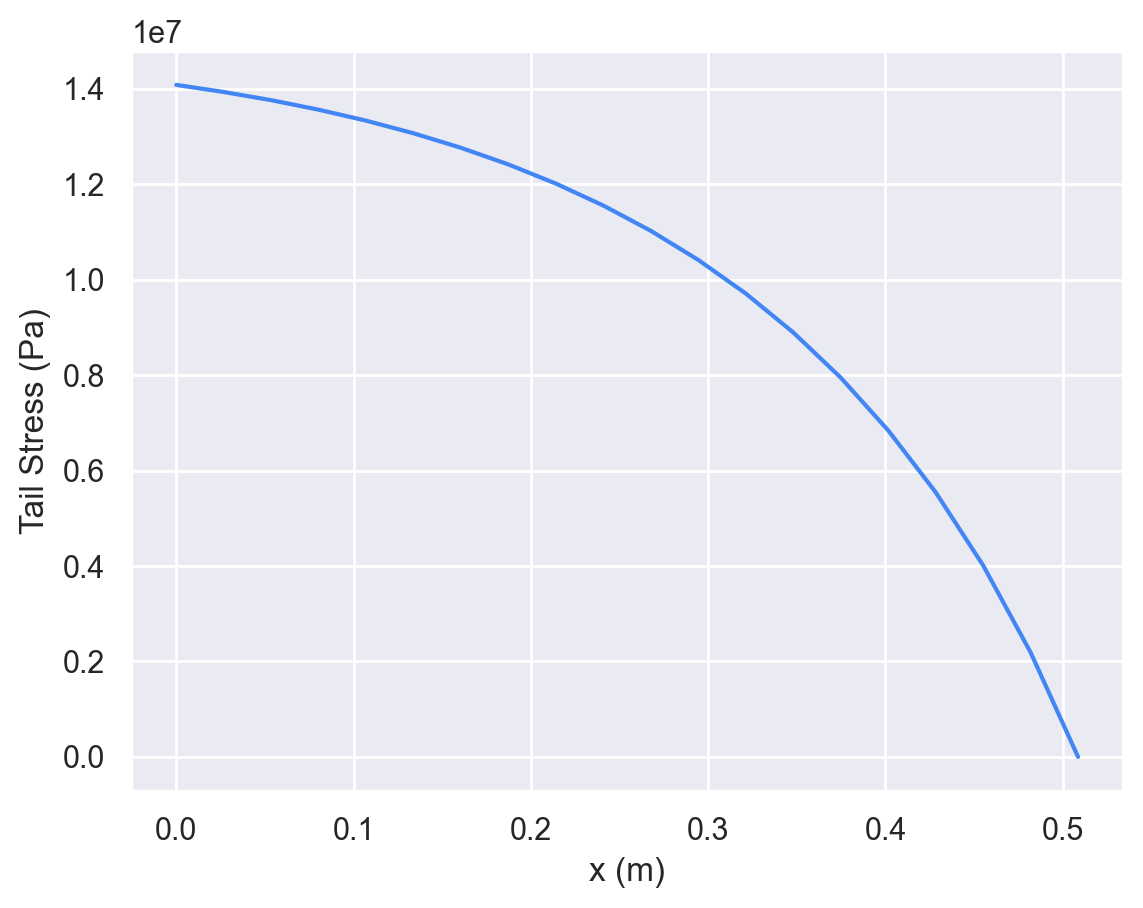

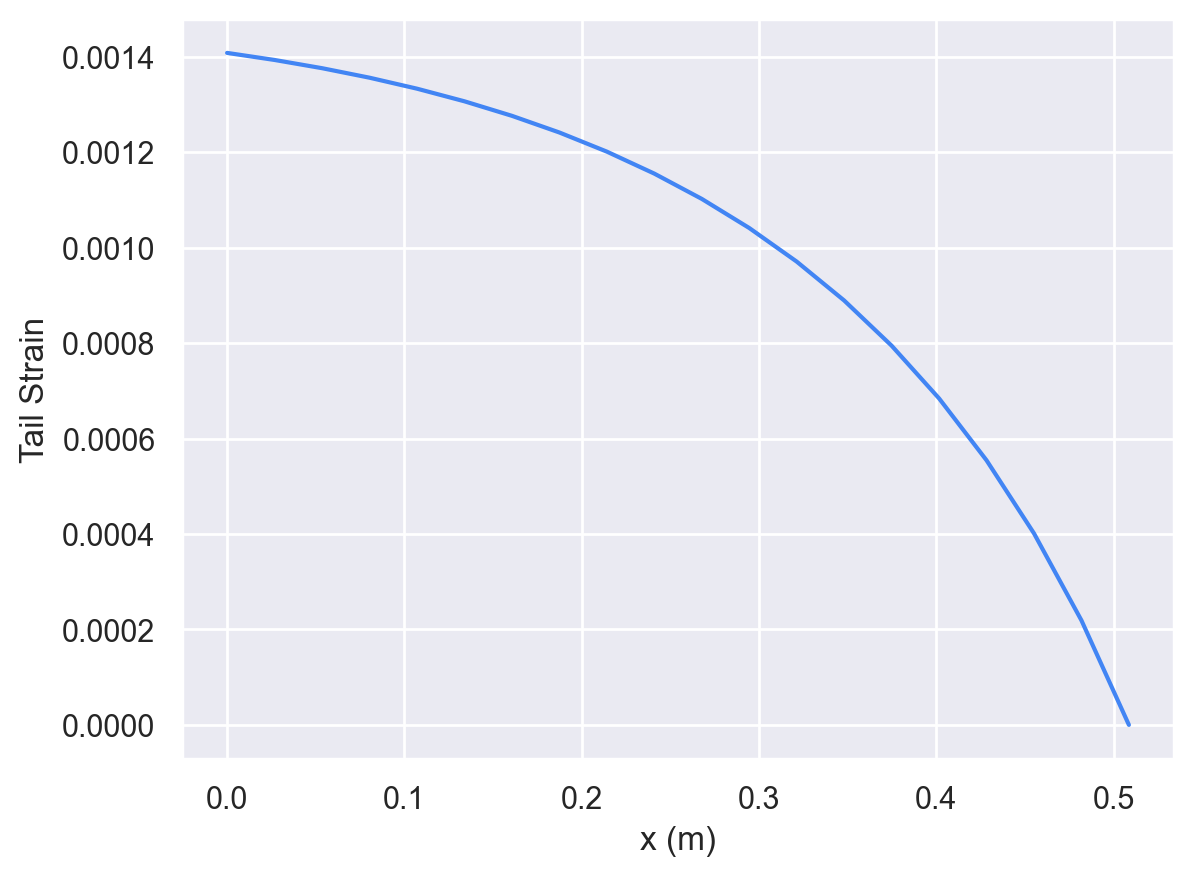

In [2]:
## Optimize wing and tail using LLM, with structures and propulsion

import aerosandbox as asb
import aerosandbox.numpy as np
import matplotlib.pyplot as plt
import numpy as np2

def run_lifting_line(airplane, alpha, c_r, c_t, b, c_r_tail, c_t_tail, b_tail, velocity, n_spanwise=20):
    # Create and run LLM
    llm = asb.LiftingLine(
        airplane=airplane,
        op_point=asb.OperatingPoint(
            velocity=velocity,
            alpha=alpha,
        ),
        spanwise_resolution=n_spanwise,
        align_trailing_vortices_with_wind=False,
        n_crit = float(5.0),  # Needs to be a float or it breaks
        xtr_lower = float(0.3),  # Same
        xtr_upper = float(0.3),  # Same
    )
    llm_results = llm.run_with_stability_derivatives(alpha=True)

    # Extract coefficients from LLM
    CL = llm_results["CL"]
    L = llm_results["L"]
    CD = llm_results["CD"]
    D = llm_results["D"]
    Cm = llm_results["Cm"]
    x_np = llm_results["x_np"]

    # Vortex y locations
    strip_y = llm.vortex_centers[:, 1]

    # Indices to sort vortex data
    sorted_indices = np.concatenate((np.arange(2*n_spanwise-1, n_spanwise-1, -1), np.arange(n_spanwise)))
    sorted_indices_tail = sorted_indices + 2 * n_spanwise

    # Sort y location data
    sorted_y = strip_y[sorted_indices]
    sorted_y_tail = strip_y[sorted_indices_tail]

    # Linearly interpolate to find chords
    sorted_chords = c_r + (c_t - c_r) * (np.abs(sorted_y) / (b / 2))
    sorted_chords_tail = c_r_tail + (c_t_tail - c_r_tail) * (np.abs(sorted_y_tail) / (b_tail / 2))

    # Extract and sort vortex strengths
    vortex_strengths = llm.vortex_strengths
    sorted_vortex_strengths = vortex_strengths[sorted_indices]
    sorted_vortex_strengths_tail = vortex_strengths[sorted_indices_tail]

    # Dynamic pressure
    q = llm.op_point.dynamic_pressure()

    # Convert vortex strength to sectional lift
    sectional_L = (2 * q / velocity) * sorted_vortex_strengths
    sectional_L_tail = (2 * q / velocity) * sorted_vortex_strengths_tail

    # Calculate lift coefficient
    cl = sectional_L / (q * sorted_chords)
    cl_tail = sectional_L_tail / (q * sorted_chords_tail)

    # Cl*c
    clc = cl * sorted_chords
    clc_tail = cl_tail * sorted_chords_tail

    # Cl*c/cref
    clc_cref = clc / airplane.c_ref
    clc_cref_tail = clc_tail / airplane.c_ref

    # Half span data for structural calculations
    y_half = sorted_y[n_spanwise:]
    L_half = sectional_L[n_spanwise:]

    # Concatenate data at the root and tip
    y_half = np.concatenate([np.array([0.0]), y_half, np.array([b/2])], axis = 0)
    L_half = np.concatenate([np.array([L_half[-1]]), L_half, np.array([0.0])], axis = 0)

    # Calculate point forces
    dy_half = np.diff(y_half)
    L_avg = 0.5 * (L_half[:-1] + L_half[1:])
    L_forces = L_avg * dy_half
    y_forces = 0.5 * (y_half[:-1] + y_half[1:])

    return L, CL, D, CD, Cm, x_np, sorted_y, sorted_y_tail, cl, cl_tail, clc_cref, clc_cref_tail, y_forces, L_forces


def drag_build_up(CD, velocity, l_fuselage, S_ref):
    
    rho = 1.18
    mu = 18.45e-6
    
    V = velocity #op point velocity
    
    ## Calculate drag of wing + tail
    
    CDg = CD
    # # Calculate total parasite/profile/pressure drag (wings + tail + fuselage + landing gear).
    
    ## Calculate drag of fuselage
    f_l = l_fuselage #fuselage length
    f_w = 0.1016 #fuselage width
    f_h = 0.0635 #fuselage height
    ff = f_l/f_h #fuselage fineness ratio
    re_f = (rho * V * f_l) / mu #Reynolds number of fuselage[-]
    Cf_f = 0.455/(np.log10(re_f)) ** 2.58 #flat-plate skin friction coefficient
    FF_f = 1 + (60/ff**3) + (ff/400) #fuselage form factor
    f_wetted = (f_h * f_w) + (2 * f_h * f_l) + (2 * f_w * f_l) #wetted area of fuselage
    CDf = Cf_f * FF_f * (f_wetted)/S_ref #fuselage drag coefficient
   
    ## Calculate drag of wheels
    #Circular wheels
    w_d = 0.0508 #wheel diameter
    w_w = 0.0175 #wheel width
    CDpi_wheel = 0.25 #empirical drag coefficient for wheel
    A_proj_w = w_d * w_w #projected area of wheel
    CDw = 2 * (CDpi_wheel * A_proj_w / S_ref) #wheel drag coefficient
    bw_d = 0.0254 #back wheel diameter
    bw_w = 0.00635 #back wheel width
    bCDpi_wheel = 0.25 #empirical drag coefficient for back wheel
    bA_proj_w = w_d * w_w #projected area of wheel
    bCDw = (bCDpi_wheel * bA_proj_w / S_ref) #wheel drag coefficient
    
    ## Calculate drag of landing gear struts
    strut_t = 0.0032 #strut thickness
    strut_c = 0.028 #strut chord
    strut_l = 0.529 #length of parabola or estimate as 3 straight lines
    re_s = (rho * V * strut_c) / mu #Reynolds number of strut
    FF_s = 1 + ((0.6/0.5) * (strut_t/strut_c) + 100 * (strut_t/strut_c)**4) #strut form factor
    Cf_s = 0.455 / (np.log10(re_s)**2.58)
    s_wetted = (2 * (strut_l * strut_c))-(.116*strut_c) + (strut_l * strut_t) #strut wetted area-- 2 * (strut_l * strut_c) + (strut_l * strut_t) - the top section that's against the fuselage and not doubly
                                                                                  #exposed to air
    CDs = Cf_s * FF_s * (s_wetted)/S_ref #strut drag coefficient
    
    ## Calculate drag of landing gear
    CDlg = 1.2 * (2*CDw + CDs) #CD landing gear mulitplied by 1.2 to account for interference
    
    #will need to add 1.1 factor to CD0 for leakages and protuberances, and then 1.6 factor on top of that (from Embry-Riddle DBF)
    ## Calculate cyclindrical prop contribution
    prop_d = .0277 # motor (cylinder) diameter [m]
    prop_l = .034 # exposed length of the cylinder [m]
    re_p = (rho * V * prop_l) / mu  # reynolds number for prop
    Cf_p = 0.455 / (np.log10(re_p) ** 2.58)
    fineness_ratio_p = prop_l / prop_d
    FF_p = 1 + (0.35 / fineness_ratio_p)
    prop_wetted = np.pi * prop_d * prop_l
    CDprop = Cf_p * FF_p * (prop_wetted / S_ref)
    
    #Put everything together
    CD_total = (1.1*(CDg +  CDf + bCDw + CDlg + CDprop))*1.6
    
    return CD_total


def predict_thrust(velocity, weight):

    #thrust = -0.0126*(velocity/2)**2 + -0.1446*(velocity/2) + 11.3390  # X2212 old
    #thrust = 12.2 + 0.215*velocity - 0.0665*velocity**2 + 7.48e-3*velocity**3 - 3.53e-4*velocity**4 + 7.08e-6*velocity**5 - 5.13e-8*velocity**6  # X2214
    thrust = (2.57*weight + 1.96) + (0.0471*weight + 0.0798) * velocity + (-1.48e-3*weight - 5.07e-3) * velocity**2

    return thrust

def beam_deflection(diam_spar, E, y_forces, L_forces, u, n_spanwise):
    # Moment of inertia calculation
    I = 0.0181 * diam_spar ** 3.73

    # Calculate shear force
    for i in range (n_spanwise-1,-1,-1):
        L_forces[i] = L_forces[i] + L_forces[i+1]

    # Create derivatives
    du = opti.derivative_of(
        variable=u,
        with_respect_to=y_forces,
        derivative_init_guess=np.zeros_like(y_forces)
    )
    ddu = opti.derivative_of(
        variable=du,
        with_respect_to=y_forces,
        derivative_init_guess=np.zeros_like(y_forces)
    )

    # Boundary conditions
    opti.subject_to([
        u[0] == 0,
        du[0] == 0,
        ddu[-1] == 0,
    ])

    # Constrain second derivative
    opti.constrain_derivative(
        variable=-E * I * ddu,
        with_respect_to=y_forces,
        derivative=L_forces
    )

    # Bending stress
    stress = E * (diam_spar / 2) * ddu

    return du, ddu, stress


def calculate_weights(S, S_tail, S_vt, b, diam_spar, x_fuselage_start, l_tail, t_tb, h_start_fuse, h_end_fuse, b_start_fuse, b_end_fuse, w_prop_max, w_batt_N):
    # Propulsion system data TODO update
    w_propeller = 0.1751487255
    w_motor = 0.55897687092
    w_ESC = 0.0588397408583
    #w_batt_av = 0.55897687092  # 1000mAh 2S liperior
    
    #w_prop = w_propeller + w_motor + w_ESC + w_batt_N
    w_prop = w_prop_max + w_batt_N
    
    # Avionics
    w_batt_av = 0.1490610623536  # Castle creations 10A BEC
    w_lidar = 0.107872932377
    w_fc = 0.274586050435
    w_gps = 0.235359408255
    w_aspd = 0.3755947096503
    w_servos = 4 * 0.0539364661886
    w_av = (w_batt_av + w_lidar + w_fc + w_gps + w_aspd + w_servos) * 1.5  # SF for wiring, TODO improve
        
    # Material weight densities
    sig_wing = 3.08176203838       # N/m^2
    sig_parklite = 0.35910209681*2   # N/m^2
    rho_carbon = 15389.224         # N/m^3
    rho_glass = 17024.34444971713  # N/m^3
    sig_tail = 2.37660248715       # N/m^2

    # Wing weight
    w_wing = S * (sig_wing + sig_parklite)

    # Tail weight
    w_tail = S_tail * sig_tail
    w_vt = S_vt * sig_tail
    
    # Spar weight
    t_spar = 0.001  # m
    r_outer = diam_spar / 2
    r_inner = r_outer - t_spar
    spar_cross_section_area = (diam_spar**2) - (np.pi * (r_inner**2))
    w_spar = rho_carbon * (b * spar_cross_section_area)

    # Tail boom weight
    V_tb = (2 * (l_tail * 0.5 * (h_start_fuse + h_end_fuse)) + 2 * (l_tail * 0.5 * (b_start_fuse + b_end_fuse))) * t_tb
    w_tb = V_tb * rho_glass
    
    # Fuselage weight
    t_fuse = 8e-5 * 4
    V_fuse = ((2 * (x_fuselage_start * h_start_fuse)) + (2 * (x_fuselage_start * b_start_fuse))) * t_fuse
    w_fuse = 2 * V_fuse * rho_glass  # 2x factor to account for bulkheads, adhesive, and hatches

    # Gear weight
    w_main = 0.6864673502
    w_tailgear = 0.1814230310312
    w_gear = w_main + w_tailgear
    
    # Total
    roughness = 1.1
    w_total = roughness * (w_prop + w_av + w_wing + w_tail + w_vt + w_vt + w_spar + w_tb + w_fuse + w_gear)

    return w_prop, w_av, w_wing, w_tail, w_vt, w_spar, w_tb, w_fuse, w_gear, w_total


def norm_cdf(x, mu, sigma):
    z = (x - mu) / (sigma * np.sqrt(2))
    return 0.5 * (1 + erf_approx(z))


def erf_approx(z):
    # Abramowitz and Stegun formula 7.1.26 for erf(z) approximation
    t = 1 / (1 + 0.3275911 * np.abs(z))
    a1, a2, a3, a4, a5 = 0.254829592, -0.284496736, 1.421413741, -1.453152027, 1.061405429
    poly = (((a5 * t + a4) * t + a3) * t + a2) * t + a1
    erf_z = 1 - poly * np.exp(-z**2)
    return np.sign(z) * erf_z


def compute_prop_efficiency(motor_rpm, v_inf, throttle):
    Thrust_prop = fitted_models["thrust"]({"velocity": v_inf, "rpm": motor_rpm})
    Torque_prop = fitted_models["torque"]({"velocity": v_inf, "rpm": motor_rpm})
    Power_prop = fitted_models["power"]({"velocity": v_inf, "rpm": motor_rpm})
   
    # Paramters
    omega = motor_rpm * (2 * np.pi) / 60 # rad/s
    Kv = 980 * (2 * np.pi) / 60 # rad/s/V
    Rm = 0.133
    Rbatt = 0.03
    Vbatt = 14.8
    I0 = 0.3
    
    # Tom code new
    Vin_mot = throttle*Vbatt
    I_mot = (Vin_mot - omega/Kv)/Rm
    Qm = ((Vin_mot - omega / Kv) / Rm - I0) / Kv
    P_shaft = Qm * omega
    n_mot = P_shaft / (I_mot * Vin_mot)
    Pin_mot = I_mot*Vin_mot
    
    n_esc = 1.6054 * (1 - 1 / (1 + 1.6519 * (throttle**0.6455)))
    Pin_esc = Pin_mot / n_esc
    
    I_batt = Pin_esc / Vbatt
    n_bat = 1 - (I_batt*Rbatt/Vbatt)
    
    #T = 0
    
    # Motor
    #Vin_mot = throttle*Vbatt
    #I_mot = (Vin_mot - omega/Kv)/Rm
    #n_mot = (1 - (I0/I_mot))/(1+(T*omega)+(I_mot*Rm*Kv/omega))
    #Pin_mot = I_mot*Vin_mot

    # ESC
    # throttle = ((omega / Kv) + (I_mot * Rm)) / Vout_batt
    #n_esc = 1.6054 * (1 - 1 / (1 + 1.6519 * (throttle**0.6455)))
    #Pin_esc = Pin_mot / n_esc

    # Battery
    #I_batt = Pin_esc / Vbatt
    #n_bat = 1 - (I_batt*Rbatt/Vbatt)

    # Wire
    n_wire = 0.98

    # Final
    n_elec = n_wire * n_bat * n_esc * n_mot
    n_propeller = (Thrust_prop * v_inf) / Power_prop
    n_prop = n_elec * n_propeller
    
    # Shaft power
    #Qm = ((Vin_mot - omega / Kv) / Rm - I0) / Kv
    #P = Qm * omega
    
    return n_prop, Thrust_prop, Power_prop, P_shaft


def battery_sizing(distance, power, velocity):
    V_cell = 3.7
    N_cells = 4        # 4S pack
    V_batt = V_cell * N_cells

    SF_lipo = 1/0.85
    SF_flighttime = 1.5

    t_flight = (distance / velocity)

    # Energy required
    energy = power * t_flight
    As = energy / V_batt
    Ah = As / 3600
    C_required_mAh = (Ah * 1000 * SF_lipo * SF_flighttime)
    
    # Flight time achieved
    minutes = t_flight / 60.0

    # Mass regression (kg)
    m_batt_kg = (C_required_mAh + 0.246) / 7300.0

    return C_required_mAh, m_batt_kg, minutes


opti = asb.Opti()

# Sensitivities
delta_CDcruise = 1.0
delta_CDstall = 1.0
delta_CDturn = 1.0
delta_CDclimb = 1.0
delta_CDvmax = 1.0
delta_CLmax = 1.0

# Geometry variables
S = opti.variable(init_guess=0.25, lower_bound=0.0, freeze=False)
AR = opti.variable(init_guess=10.0, lower_bound=7.0, upper_bound=12.0, freeze=False)
taper = opti.variable(init_guess=0.6, lower_bound=0.4, upper_bound=1.0, freeze=False)
#taper = opti.variable(init_guess=1.0, lower_bound=0.4, upper_bound=1.0, freeze=True)
twist = opti.variable(init_guess=0.0, lower_bound=-20.0, upper_bound=20.0, freeze=True)

# Planform dimensions
b = np.sqrt(S*AR)
c_r = (2 * S) / (b * (1 + taper))
c_t = taper * c_r

# Horizontal Tail
S_tail = opti.variable(init_guess=0.05, lower_bound=0.0, freeze=False)
AR_tail = opti.variable(init_guess=5, freeze=True)
taper_tail = opti.variable(init_guess=0.7, lower_bound=0.5, upper_bound=1.0, freeze=True)
x_tail = opti.variable(init_guess=0.6, lower_bound=0.4, upper_bound=0.8, freeze=False)

b_tail = np.sqrt(S_tail * AR_tail)
c_r_tail = (2 * S_tail) / (b_tail * (1 + taper_tail))
c_t_tail = taper_tail * c_r_tail

# Vertical Tail
S_vt = opti.variable(init_guess=0.04, lower_bound=0.0, upper_bound=0.05, freeze=False)
AR_vt = opti.variable(init_guess=2, freeze=True)
taper_vt = opti.variable(init_guess=0.5, lower_bound=0.5, upper_bound=1.0, freeze=True)
b_vt = np.sqrt(S_vt * AR_vt)
c_r_vt = (2 * S_vt) / (b_vt * (1 + taper_vt))
c_t_vt = taper_vt * c_r_vt

# Trim variables and values
x_cg = opti.variable(init_guess=0.0)
elevator_cruise = opti.variable(init_guess=0.0, lower_bound=-20.0, upper_bound=20.0, freeze=False)
elevator_stall = opti.variable(init_guess=-8.0, lower_bound=-20.0, upper_bound=20.0, freeze=False)
elevator_turn = opti.variable(init_guess=-3.5, lower_bound=-20.0, upper_bound=20.0, freeze=False)
elevator_climb = opti.variable(init_guess=0.0, lower_bound=-20.0, upper_bound=20.0, freeze=False)
elevator_vmax = opti.variable(init_guess=2.0, lower_bound=-20.0, upper_bound=20.0, freeze=False)
SM = 0.2

# Speeds
v_stall_real = opti.variable(init_guess=10, lower_bound=0, freeze=False)
v_stall_set = 1.05 * v_stall_real
v_min = 1.2 * v_stall_set
v_cruise = 1.2 * v_stall_set + 3
v_max = 1.5 * v_cruise

# Weight
W = 15.5688

# Density
rho = 1.18

# Airfoils
#AF_wing_root = asb.Airfoil(name="FX63137", coordinates="./content/FX 63-137.dat")
#AF_wing_root = asb.Airfoil(name="psu94097", coordinates="./content/psu94097.dat")
#AF_wing_root = asb.Airfoil(name="dae11.dat", coordinates="./content/dae11.dat")
AF_wing_root = asb.Airfoil("sd7062")
#F_wing_root = asb.Airfoil("s1223")
#t_max_root = 0.137
t_max_root = 0.14

#AF_wing_tip = asb.Airfoil(name="FX63137", coordinates="./content/FX 63-137.dat")
#AF_wing_tip = asb.Airfoil(name="psu94097", coordinates="./content/psu94097.dat")
#AF_wing_tip = asb.Airfoil(name="dae11.dat", coordinates="./content/dae11.dat")
AF_wing_tip = asb.Airfoil("sd7062")
#AF_wing_tip = asb.Airfoil("s1223")
#t_max_tip = 0.137
t_max_tip = 0.14

AF_tail = asb.Airfoil("naca0012")

# Fuselage
z_offset = 0.05
x_fuselage_start = 0.3
l_fuselage = x_fuselage_start + x_tail + c_r_tail

h_start_fuse = 0.0635
h_end_fuse = 0.0508

b_start_fuse = 0.1016
b_end_fuse = 0.03048

# vertical tail
rud_hinge = 0.4
elev_hinge = 0.4
offset_vt = c_r_vt * rud_hinge

# Define an airplane for each flight condition to allow for trimming
airplane_stability = asb.Airplane(
    name="Airplane",
    xyz_ref=[x_cg, 0, 0],
    wings=[
        asb.Wing(
            name="Wing",
            symmetric=True,
            xsecs=[
                asb.WingXSec(
                    xyz_le = [0, 0, z_offset],
                    chord = c_r,
                    airfoil = AF_wing_root,
                ),
                asb.WingXSec(
                    xyz_le = [0.25*(c_r-c_t), b/2, z_offset],
                    chord = c_t,
                    airfoil = AF_wing_tip,
                    twist = twist,
                ),
            ]
        ),
        asb.Wing(
            name="Wing",
            symmetric=True,
            xsecs=[
                asb.WingXSec(
                    xyz_le = [0, 0, 0],
                    chord = c_r_tail,
                    airfoil = AF_tail,
                ),
                asb.WingXSec(
                    xyz_le = [(1-elev_hinge)*(c_r_tail-c_t_tail), b_tail/2, 0],
                    chord = c_t_tail,
                    airfoil = AF_tail,
                ),
            ]
        ).translate([x_tail, 0, 0]),
        asb.Wing(
            name="Wing",
            symmetric=False,
            xsecs=[
                asb.WingXSec(
                    xyz_le = [-(c_r_vt - c_r_tail - offset_vt), 0, 0],
                    chord = c_r_vt,
                    airfoil = AF_tail,
                ),
                asb.WingXSec(
                    xyz_le = [-(c_r_vt - c_r_tail - offset_vt) + (1-rud_hinge)*(c_r_vt-c_t_vt), 0, b_vt],
                    chord = c_t_vt,
                    airfoil = AF_tail,
                ),
            ]
        ).translate([x_tail, 0, 0]),
    ],
    fuselages=[
        asb.Fuselage(
            name="Fuselage",
            xsecs=[
                asb.FuselageXSec(
                    xyz_c=[l_fuselage * xi - x_fuselage_start, 0, 0],
                    radius=0.5*asb.Airfoil("naca0012").local_thickness(x_over_c=xi)
                )
                for xi in np.cosspace(0, 1, 30)
            ]
        )
    ]
)

airplane_cruise = asb.Airplane(
    name="Airplane",
    xyz_ref=[x_cg, 0, 0],
    wings=[
        asb.Wing(
            name="Wing",
            symmetric=True,
            xsecs=[
                asb.WingXSec(
                    xyz_le = [0, 0, z_offset],
                    chord = c_r,
                    airfoil = AF_wing_root,
                ),
                asb.WingXSec(
                    xyz_le = [0.25*(c_r-c_t), b/2, z_offset],
                    chord = c_t,
                    airfoil = AF_wing_tip,
                    twist = twist,
                ),
            ]
        ),
        asb.Wing(
            name="Wing",
            symmetric=True,
            xsecs=[
                asb.WingXSec(
                    xyz_le = [0, 0, 0],
                    chord = c_r_tail,
                    airfoil = AF_tail,
                    twist = elevator_cruise,
                ),
                asb.WingXSec(
                    xyz_le = [0.25*(c_r_tail-c_t_tail), b_tail/2, 0],
                    chord = c_t_tail,
                    airfoil = AF_tail,
                    twist = elevator_cruise,
                ),
            ]
        ).translate([x_tail, 0, 0])
    ],
)

airplane_stall = asb.Airplane(
    name="Airplane",
    xyz_ref=[x_cg, 0, 0],
    wings=[
        asb.Wing(
            name="Wing",
            symmetric=True,
            xsecs=[
                asb.WingXSec(
                    xyz_le = [0, 0, z_offset],
                    chord = c_r,
                    airfoil = AF_wing_root,
                ),
                asb.WingXSec(
                    xyz_le = [0.25*(c_r-c_t), b/2, z_offset],
                    chord = c_t,
                    airfoil = AF_wing_tip,
                    twist = twist,
                ),
            ]
        ),
        asb.Wing(
            name="Wing",
            symmetric=True,
            xsecs=[
                asb.WingXSec(
                    xyz_le = [0, 0, 0],
                    chord = c_r_tail,
                    airfoil = AF_tail,
                    twist = elevator_stall,
                ),
                asb.WingXSec(
                    xyz_le = [0.25*(c_r_tail-c_t_tail), b_tail/2, 0],
                    chord = c_t_tail,
                    airfoil = AF_tail,
                    twist = elevator_stall,
                ),
            ]
        ).translate([x_tail, 0, 0])
    ],
)

airplane_turn = asb.Airplane(
    name="Airplane",
    xyz_ref=[x_cg, 0, 0],
    wings=[
        asb.Wing(
            name="Wing",
            symmetric=True,
            xsecs=[
                asb.WingXSec(
                    xyz_le = [0, 0, z_offset],
                    chord = c_r,
                    airfoil = AF_wing_root,
                ),
                asb.WingXSec(
                    xyz_le = [0.25*(c_r-c_t), b/2, z_offset],
                    chord = c_t,
                    airfoil = AF_wing_tip,
                    twist = twist,
                ),
            ]
        ),
        asb.Wing(
            name="Wing",
            symmetric=True,
            xsecs=[
                asb.WingXSec(
                    xyz_le = [0, 0, 0],
                    chord = c_r_tail,
                    airfoil = AF_tail,
                    twist = elevator_turn,
                ),
                asb.WingXSec(
                    xyz_le = [0.25*(c_r_tail-c_t_tail), b_tail/2, 0],
                    chord = c_t_tail,
                    airfoil = AF_tail,
                    twist = elevator_turn,
                ),
            ]
        ).translate([x_tail, 0, 0])
    ],
)

airplane_climb = asb.Airplane(
    name="Airplane",
    xyz_ref=[x_cg, 0, 0],
    wings=[
        asb.Wing(
            name="Wing",
            symmetric=True,
            xsecs=[
                asb.WingXSec(
                    xyz_le = [0, 0, z_offset],
                    chord = c_r,
                    airfoil = AF_wing_root,
                ),
                asb.WingXSec(
                    xyz_le = [0.25*(c_r-c_t), b/2, z_offset],
                    chord = c_t,
                    airfoil = AF_wing_tip,
                    twist = twist,
                ),
            ]
        ),
        asb.Wing(
            name="Wing",
            symmetric=True,
            xsecs=[
                asb.WingXSec(
                    xyz_le = [0, 0, 0],
                    chord = c_r_tail,
                    airfoil = AF_tail,
                    twist = elevator_climb,
                ),
                asb.WingXSec(
                    xyz_le = [0.25*(c_r_tail-c_t_tail), b_tail/2, 0],
                    chord = c_t_tail,
                    airfoil = AF_tail,
                    twist = elevator_climb,
                ),
            ]
        ).translate([x_tail, 0, 0])
    ],
)

airplane_vmax = asb.Airplane(
    name="Airplane",
    xyz_ref=[x_cg, 0, 0],
    wings=[
        asb.Wing(
            name="Wing",
            symmetric=True,
            xsecs=[
                asb.WingXSec(
                    xyz_le = [0, 0, z_offset],
                    chord = c_r,
                    airfoil = AF_wing_root,
                ),
                asb.WingXSec(
                    xyz_le = [0.25*(c_r-c_t), b/2, z_offset],
                    chord = c_t,
                    airfoil = AF_wing_tip,
                    twist = twist,
                ),
            ]
        ),
        asb.Wing(
            name="Wing",
            symmetric=True,
            xsecs=[
                asb.WingXSec(
                    xyz_le = [0, 0, 0],
                    chord = c_r_tail,
                    airfoil = AF_tail,
                    twist = elevator_vmax,
                ),
                asb.WingXSec(
                    xyz_le = [0.25*(c_r_tail-c_t_tail), b_tail/2, 0],
                    chord = c_t_tail,
                    airfoil = AF_tail,
                    twist = elevator_vmax,
                ),
            ]
        ).translate([x_tail, 0, 0])
    ],
)

# Paneling parameters
n_spanwise_llm = 10
n_spanwise_vlm = 10
n_chordwise_vlm = 5

# Calculate neutral point using VLM
vlm = asb.VortexLatticeMethod(
    airplane = airplane_stability,
    op_point = asb.OperatingPoint(
        velocity = v_cruise,
        alpha = 0,
    ),
    spanwise_resolution = n_spanwise_vlm,
    chordwise_resolution = n_chordwise_vlm,
    align_trailing_vortices_with_wind = True,
)
vlm_results = vlm.run_with_stability_derivatives(alpha = True)

x_np_vlm = vlm_results["x_np"]
Cma_vlm = vlm_results["Cma"]
CLa_vlm = vlm_results["CLa"]
SM_check = -Cma_vlm/CLa_vlm

opti.subject_to([
    x_cg == x_np_vlm - SM * airplane_cruise.c_ref,
])

# Propulsion
w_prop_max = opti.variable(init_guess=3.0, lower_bound=0, upper_bound=15, freeze=False)

rpm_cruise = opti.variable(init_guess=10000, lower_bound=0, upper_bound=16000, freeze=False)
rpm_stall = opti.variable(init_guess=10000, lower_bound=0, upper_bound=16000, freeze=False)
rpm_turn = opti.variable(init_guess=10000, lower_bound=0, upper_bound=16000, freeze=False)
rpm_climb = opti.variable(init_guess=10000, lower_bound=0, upper_bound=16000, freeze=False)
rpm_vmax = opti.variable(init_guess=10000, lower_bound=0, upper_bound=16000, freeze=False)

tau_cruise = opti.variable(init_guess=0.5, lower_bound=0, upper_bound=1, freeze=False)
tau_stall = opti.variable(init_guess=0.5, lower_bound=0, upper_bound=1, freeze=False)
tau_turn = opti.variable(init_guess=0.5, lower_bound=0, upper_bound=1, freeze=False)
tau_climb = opti.variable(init_guess=0.5, lower_bound=0, upper_bound=1, freeze=False)
tau_vmax = opti.variable(init_guess=0.5, lower_bound=0, upper_bound=1, freeze=False)

# Cruise LLM
alpha_cruise = opti.variable(init_guess = -0.5, lower_bound = -5, upper_bound = 20)
L_cruise, CL_cruise, D_cruise, CD_cruise, Cm_cruise, x_np_cruise, sorted_y_cruise, sorted_y_tail_cruise, cl_cruise, cl_tail_cruise, clc_cref_cruise, clc_cref_tail_cruise, y_forces_cruise, L_forces_cruise = run_lifting_line(airplane_cruise, alpha_cruise, c_r, c_t, b, c_r_tail, c_t_tail, b_tail, v_cruise, n_spanwise_llm)

# cruise drag
CD_tot_cruise = drag_build_up(CD_cruise, v_cruise, l_fuselage, S) * delta_CDcruise
D_cruise_real = 0.5 * rho * v_cruise**2 * CD_tot_cruise * S

T_cruise = predict_thrust(v_cruise, w_prop_max)
prop_e_cruise, Thrust_prop_cruise, Power_prop_cruise, P_cruise2 = compute_prop_efficiency(rpm_cruise, v_cruise, tau_cruise)

P_cruise = 0.5 * (1/prop_e_cruise) * rho * v_cruise**3 * S * CD_tot_cruise

opti.subject_to([
    L_cruise == W,
    Cm_cruise == 0,
    D_cruise_real < T_cruise,
    D_cruise_real == Thrust_prop_cruise,
])

# Stall LLM
alpha_stall = opti.variable(init_guess = 10.0, lower_bound = -5, upper_bound = 20)
L_stall, CL_stall, D_stall, CD_stall, Cm_stall, x_np_stall, sorted_y_stall, sorted_y_tail_stall, cl_stall, cl_tail_stall, clc_cref_stall, clc_cref_tail_stall, y_forces_stall, L_forces_stall = run_lifting_line(airplane_stall, alpha_stall, c_r, c_t, b, c_r_tail, c_t_tail, b_tail, v_stall_real, n_spanwise_llm)
T_stall = predict_thrust(v_stall_real, w_prop_max)

# stall drag
CD_tot_stall = drag_build_up(CD_stall, v_stall_real, l_fuselage, S) * delta_CDstall
D_stall_real = 0.5 * rho * v_stall_real**2 * CD_tot_stall * S

T_stall = predict_thrust(v_stall_real, w_prop_max)
prop_e_stall, Thrust_prop_stall, Power_prop_stall, P_stall2 = compute_prop_efficiency(rpm_stall, v_stall_real, tau_stall)

P_stall = 0.5 * (1/prop_e_stall) * rho * v_stall_real**3 * S * CD_tot_stall

opti.subject_to([
    L_stall == W * delta_CLmax,
    Cm_stall == 0,
    D_stall_real < T_stall,
    D_stall_real == Thrust_prop_stall,
])

# Turn LLM
r_turn = 40 / 3.281
g = 9.81
phi_turn = np.arctan(v_cruise**2 / (r_turn * g))

alpha_turn = opti.variable(init_guess = 4.0, lower_bound = -5, upper_bound = 20)
L_turn, CL_turn, D_turn, CD_turn, Cm_turn, x_np_turn, sorted_y_turn, sorted_y_tail_turn, cl_turn, cl_tail_turn, clc_cref_turn, clc_cref_tail_turn, y_forces_turn, L_forces_turn = run_lifting_line(airplane_turn, alpha_turn, c_r, c_t, b, c_r_tail, c_t_tail, b_tail, v_cruise, n_spanwise_llm)
T_turn = predict_thrust(v_cruise, w_prop_max)

# turn drag
CD_tot_turn = drag_build_up(CD_turn, v_cruise, l_fuselage, S) * delta_CDturn
D_turn_real = 0.5 * rho * v_cruise**2 * CD_tot_turn * S

T_turn = predict_thrust(v_cruise, w_prop_max)
prop_e_turn, Thrust_prop_turn, Power_prop_turn, P_turn2 = compute_prop_efficiency(rpm_turn, v_cruise, tau_turn)

P_turn = 0.5 * (1/prop_e_turn) * rho * v_cruise**3 * S * CD_tot_turn

opti.subject_to([
    L_turn * np.cos(phi_turn) == W,
    Cm_turn == 0,
    D_turn_real < T_turn,
    D_turn_real == Thrust_prop_turn,
])

# Climb LLM
gamma_climb = np.deg2rad(6)

alpha_climb = opti.variable(init_guess = -0.5, lower_bound = -5, upper_bound = 20)
L_climb, CL_climb, D_climb, CD_climb, Cm_climb, x_np_climb, sorted_y_climb, sorted_y_tail_climb, cl_climb, cl_tail_climb, clc_cref_climb, clc_cref_tail_climb, y_forces_climb, L_forces_climb = run_lifting_line(airplane_climb, alpha_climb, c_r, c_t, b, c_r_tail, c_t_tail, b_tail, v_cruise, n_spanwise_llm)
T_climb = predict_thrust(v_cruise, w_prop_max)

# climb drag
CD_tot_climb = drag_build_up(CD_climb, v_cruise, l_fuselage, S) * delta_CDclimb
D_climb_real = 0.5 * rho * v_cruise**2 * CD_tot_climb * S

T_climb = predict_thrust(v_cruise, w_prop_max)
prop_e_climb, Thrust_prop_climb, Power_prop_climb, P_climb2 = compute_prop_efficiency(rpm_climb, v_cruise, tau_climb)

P_climb = (0.5 * (1/prop_e_climb) * rho * v_cruise**3 * S * CD_tot_climb) + ((v_cruise * W * np.sin(gamma_climb)) / prop_e_climb)

opti.subject_to([
    L_climb * np.cos(gamma_climb) == W,
    Cm_climb == 0,
    D_climb_real < T_climb - W * np.sin(gamma_climb),
    D_climb_real == Thrust_prop_climb - W * np.sin(gamma_climb),
])

# Level Vmax LLM
alpha_vmax = opti.variable(init_guess = -4, lower_bound = -5, upper_bound = 20)
L_vmax, CL_vmax, D_vmax, CD_vmax, Cm_vmax, x_np_vmax, sorted_y_vmax, sorted_y_tail_vmax, cl_vmax, cl_tail_vmax, clc_cref_vmax, clc_cref_tail_vmax, y_forces_vmax, L_forces_vmax = run_lifting_line(airplane_vmax, alpha_vmax, c_r, c_t, b, c_r_tail, c_t_tail, b_tail, v_max, n_spanwise_llm)
T_vmax = predict_thrust(v_max, w_prop_max)

# Vmax drag
CD_tot_vmax = drag_build_up(CD_vmax, v_max, l_fuselage, S) * delta_CDvmax
D_vmax_real = 0.5 * rho * v_max**2 * CD_tot_vmax * S

T_vmax = predict_thrust(v_max, w_prop_max)
prop_e_vmax, Thrust_prop_vmax, Power_prop_vmax, P_vmax2 = compute_prop_efficiency(rpm_vmax, v_max, tau_vmax)

P_vmax = 0.5 * (1/prop_e_vmax) * rho * v_max**3 * S * CD_tot_vmax

opti.subject_to([
    L_vmax == W,
    Cm_vmax == 0,
    D_vmax_real < T_vmax,
    D_vmax_real == Thrust_prop_vmax,
])

opti.subject_to([
    Power_prop_cruise == P_cruise2,
    Power_prop_stall == P_stall2,
    Power_prop_turn == P_turn2,
    Power_prop_climb == P_climb2,
    Power_prop_vmax == P_vmax2,
])

# Battery
C_required_mAh_climb, m_batt_kg_climb, minutes_climb = battery_sizing(170, P_climb, v_cruise)
C_required_mAh_turn, m_batt_kg_turn, minutes_turn = battery_sizing(4*76, P_turn, v_cruise)
C_required_mAh_cruise, m_batt_kg_cruise, minutes_cruise = battery_sizing(4*392, P_cruise, v_cruise)
C_required_mAh = C_required_mAh_climb + C_required_mAh_turn + C_required_mAh_cruise
m_batt_kg = m_batt_kg_climb + m_batt_kg_turn + m_batt_kg_cruise
w_batt_N = m_batt_kg * 9.81
minutes = minutes_climb + minutes_turn + minutes_cruise

# Spar Bending
xoverc_spar = 0.3
cap_width = opti.variable(init_guess = 0.003, lower_bound = 0, upper_bound = 0.01, freeze=True)
cap_thk = cap_width * (0.0006 / 0.003)

diam_spar = opti.variable(init_guess = 0.01, lower_bound = 0.006, upper_bound = 0.03, freeze = False)
E = 35e9
u = opti.variable(init_guess = np.linspace(0, 0.05, np.length(y_forces_turn)) ** 2)

du, ddu, stress = beam_deflection(diam_spar, E, y_forces_turn, L_forces_turn, u, n_spanwise_llm)

opti.subject_to([
    du[-1] < np.deg2rad(8),
])

# Tail to Wing AC
l_tail = airplane_stability.wings[1].aerodynamic_center()[0] - airplane_stability.wings[0].aerodynamic_center()[0]
l_vt = airplane_stability.wings[2].aerodynamic_center()[0] - airplane_stability.wings[0].aerodynamic_center()[0]

# Tail Boom Bending
P_ht = 0.5 * rho * v_max**2 * 1.5 * S_tail

t_tb = opti.variable(init_guess=2*8e-5, lower_bound=8e-5, upper_bound=0.0016, freeze=False)
E_tb = 10e9
n_tb = 20

h_tb = np.linspace(h_start_fuse, h_end_fuse, n_tb)
b_tb = np.linspace(b_start_fuse, b_end_fuse, n_tb)
L_tb = airplane_stability.wings[1].aerodynamic_center()[0] - x_cg
x_tb = np.linspace(0, L_tb, n_tb)

I_tb = (b_tb * h_tb**3 - (b_tb - t_tb) * (h_tb - t_tb)**3) / 12
M_tb = P_ht * (L_tb - x_tb)

w_tb = opti.variable(init_guess=np.linspace(0, 0.05, n_tb)**2)

dw_dx = opti.derivative_of(
    variable=w_tb,
    with_respect_to=x_tb,
    derivative_init_guess=np.zeros_like(x_tb)
)
d2w_dx2 = opti.derivative_of(
    variable=dw_dx,
    with_respect_to=x_tb,
    derivative_init_guess=np.zeros_like(x_tb)
)

opti.subject_to(E_tb * I_tb * d2w_dx2 == M_tb)

opti.subject_to([
    w_tb[0] == 0,
    dw_dx[0] == 0,
])

sigma_tb = M_tb * (h_tb / 2) / I_tb
epsilon_tb = sigma_tb / E_tb

opti.subject_to([
    dw_dx[-1] < np.deg2rad(1),
])

# Geometric Constraints
t_root = c_r * t_max_root
t_tip = c_t * t_max_tip

t_servo = 0.0115
t_rib = 0.008

opti.subject_to([
    #t_root > diam_spar + t_rib,
    #t_tip > diam_spar + t_rib,
    #0.5*(t_root + t_tip) > t_servo + t_rib
])

cht = 0.42
cvt = 0.03

opti.subject_to([
    S_tail == (cht * airplane_stability.c_ref * S) / (l_tail),
    #S_tail == 0.2 * S,
    S_vt == (cvt * b * S) / (l_vt),
])

# Calculate weights
w_prop, w_av, w_wing, w_tail, w_vt, w_spar, weight_tb, w_fuse, w_gear, w_total = calculate_weights(S, S_tail, S_vt, b, diam_spar, x_fuselage_start, l_tail, t_tb, h_start_fuse, h_end_fuse, b_start_fuse, b_end_fuse, w_prop_max, w_batt_N)

w_payload_lb = 3.5 - w_total/4.448

# Calculate score
mu_max = 6.645098344016
sigma_max = 1.738169957638
mu_avg = 3.107432180653
sigma_avg = 1.450002302936

cdf_val_delivery = 1 - norm_cdf(v_min - 8.0, mu_avg, sigma_avg)
cdf_val_cruise = norm_cdf(v_cruise, mu_max, sigma_max)

takeoff = 1 + (2 * w_payload_lb)
delivery = (1 + (4 * w_payload_lb)) * cdf_val_delivery
#RTB = 1 + (3 * w_payload_lb)
RTB = 1
bonus = 2
score = (takeoff + delivery + RTB + bonus) * cdf_val_cruise

# Objective and solution
opti.maximize(score)
sol = opti.solve(behavior_on_failure='return_last', max_iter=100)

# Draw final airplane and print relevant values
sol(airplane_stability).draw_three_view()

print(f"\nWing Area: {sol(S)}")
print(f"Aspect Ratio: {sol(AR)}")
print(f"Taper Ratio: {sol(taper)}")
print(f"Twist: {sol(twist)} deg\n")

print(f"Tail Area: {sol(S_tail)}")
print(f"Tail Aspect Ratio: {sol(AR_tail)}")
print(f"Tail Taper Ratio: {sol(taper_tail)}\n")

print(f"Wingspan: {sol(b)} m")
print(f"Root Chord: {sol(c_r)} m")
print(f"Tip Chord: {sol(c_t)} m\n")

print(f"Horizontal Tail Span: {sol(b_tail)} m")
print(f"Horizontal Tail Root Chord: {sol(c_r_tail)} m")
print(f"Horizontal Tail Tip Chord: {sol(c_t_tail)} m")
print(f"Tail Offset: {sol(x_tail)} m")
print(f"Horizontal Tail Length from Wing: {sol(l_tail)} m\n")

print(f"Vertical Tail Span: {sol(b_vt)} m")
print(f"Vertical Tail Root Chord: {sol(c_r_vt)} m")
print(f"Vertical Tail Tip Chord: {sol(c_t_vt)} m")
print(f"Vertical Tail Length from Wing: {sol(l_vt)} m\n")

print(f"Real Stall Speed: {sol(v_stall_real)} m/s")
print(f"Set Stall Speed: {sol(v_stall_set)} m/s")
print(f"Minimium Speed: {sol(v_min)} m/s")
print(f"Cruise Speed: {sol(v_cruise)} m/s")
print(f"Max Speed: {sol(v_max)} m/s\n")

print(f"x_cg: {sol(x_cg)} m")
print(f"x_np: {sol(x_np_vlm)} m")
print(f"SM: {sol(SM_check)}\n")

print(f"Cruise RPM: {sol(rpm_cruise)}")
print(f"Stall RPM: {sol(rpm_stall)}")
print(f"Turn RPM: {sol(rpm_turn)}")
print(f"Climb RPM: {sol(rpm_climb)}")
print(f"Vmax RPM: {sol(rpm_vmax)}\n")

print(f"Cruise Efficiency: {sol(prop_e_cruise)}")
print(f"Stall Efficiency: {sol(prop_e_stall)}")
print(f"Turn Efficiency: {sol(prop_e_turn)}")
print(f"Climb Efficiency: {sol(prop_e_climb)}")
print(f"Vmax Efficiency: {sol(prop_e_vmax)}\n")

print(f"Cruise Thrust: {sol(Thrust_prop_cruise)} N")
print(f"Stall Thrust: {sol(Thrust_prop_stall)} N")
print(f"Turn Thrust: {sol(Thrust_prop_turn)} N")
print(f"Climb Thrust: {sol(Thrust_prop_climb)} N")
print(f"Vmax Thrust: {sol(Thrust_prop_vmax)} N\n")

print(f"Cruise Electrical Power: {sol(P_cruise)} W")
print(f"Stall Electrical Power: {sol(P_stall)} W")
print(f"Turn Electrical Power: {sol(P_turn)} W")
print(f"Climb Electrical Power: {sol(P_climb)} W")
print(f"Vmax Electrical Power: {sol(P_vmax)} W\n")

print(f"Cruise Shaft Power: {sol(Power_prop_cruise)} W")
print(f"Stall Shaft Power: {sol(Power_prop_stall)} W")
print(f"Turn Shaft Power: {sol(Power_prop_turn)} W")
print(f"Climb Shaft Power: {sol(Power_prop_climb)} W")
print(f"Vmax Shaft Power: {sol(Power_prop_vmax)} W\n")

print(f"Cruise Throttle: {sol(tau_cruise)}")
print(f"Stall Throttle: {sol(tau_stall)}")
print(f"Turn Throttle: {sol(tau_turn)}")
print(f"Climb Throttle: {sol(tau_climb)}")
print(f"Vmax Throttle: {sol(tau_vmax)}\n")

print(f"Cruise Alpha: {sol(alpha_cruise)} deg")
print(f"Cruise CL: {sol(CL_cruise)}")
print(f"Cruise L: {sol(L_cruise)} N")
print(f"Cruise CD: {sol(CD_tot_cruise)}")
print(f"Cruise D: {sol(D_cruise_real)} N")
print(f"Cruise Required T: {sol(T_cruise)} N")
print(f"Cruise Cm: {sol(Cm_cruise)}")
print(f"Cruise Elevator: {sol(elevator_cruise)} deg\n")

print(f"Stall Alpha: {sol(alpha_stall)} deg")
print(f"Stall CL: {sol(CL_stall)}")
print(f"Stall L: {sol(L_stall)} N")
print(f"Stall CD: {sol(CD_tot_stall)}")
print(f"Stall D: {sol(D_stall_real)} N")
print(f"Stall Required T: {sol(T_stall)} N")
print(f"Stall Cm: {sol(Cm_stall)}")
print(f"Stall Elevator: {sol(elevator_stall)} deg\n")

print(f"Turn Alpha: {sol(alpha_turn)} deg")
print(f"Turn CL: {sol(CL_turn)}")
print(f"Turn L: {sol(L_turn)} N")
print(f"Turn CD: {sol(CD_tot_turn)}")
print(f"Turn D: {sol(D_turn_real)} N")
print(f"Turn Required T: {sol(T_turn)} N")
print(f"Turn Cm: {sol(Cm_turn)}")
print(f"Turn Elevator: {sol(elevator_turn)} deg\n")

print(f"Climb Alpha: {sol(alpha_climb)} deg")
print(f"Climb CL: {sol(CL_climb)}")
print(f"Climb L: {sol(L_climb)} N")
print(f"Climb CD: {sol(CD_tot_climb)}")
print(f"Climb D: {sol(D_climb_real)} N")
print(f"Climb Required T: {sol(T_climb)} N")
print(f"Climb Cm: {sol(Cm_climb)}")
print(f"Climb Elevator: {sol(elevator_climb)} deg\n")

print(f"Level Vmax Alpha: {sol(alpha_vmax)} deg")
print(f"Level Vmax CL: {sol(CL_vmax)}")
print(f"Level Vmax L: {sol(L_vmax)} N")
print(f"Level Vmax CD: {sol(CD_tot_vmax)}")
print(f"Level Vmax D: {sol(D_vmax_real)} N")
print(f"Level Vmax Required T: {sol(T_vmax)} N")
print(f"Level Vmax Cm: {sol(Cm_vmax)}")
print(f"Level Vmax Elevator: {sol(elevator_vmax)} deg\n")

print(f"C_required_mAh: {sol(C_required_mAh)} mAh")
print(f"m_batt_kg: {sol(m_batt_kg)} kg")
print(f"Minutes: {sol(minutes)} min\n")

print(f"Spar Diameter: {sol(diam_spar)} m")
print(f"Maximum Spar Deflection: {sol(u[-1])} m")
print(f"Maximum Spar Angle: {sol(du[-1])} rad")
print(f"Maximum Stress: {sol(stress[0]/1e6)} MPa\n")

print(f"Tail Boom Thickness: {sol(t_tb)} m")
print(f"Horizontal Tail Load: {sol(P_ht)} N")
print(f"Maximum Tail Boom Deflection: {sol(w_tb[-1])} m")
print(f"Maximum Tail Boom Angle: {sol(dw_dx[-1])} rad")
print(f"Maximum Tail Boom Stress: {sol(sigma_tb[0]/1e6)} MPa")
print(f"Maximum Tail Boom Strain: {sol(epsilon_tb[0])}\n")

print(f"Root Thickness: {sol(t_root)} m")
print(f"Midpoint Thickness: {sol(0.5*(t_root + t_tip))} m")
print(f"Tip Thickness: {sol(t_tip)} m")
print(f"Spar Required Thickness: {sol(diam_spar + t_rib)} m")
print(f"Servo Required Thickness: {sol(t_servo + t_rib)} m\n")

print(f"Propulsion Weight: {sol(w_prop)} N")
print(f"Avionics Weight: {sol(w_av)} N")
print(f"Wing Weight: {sol(w_wing)} N")
print(f"Horizontal Tail Weight: {sol(w_tail)} N")
print(f"Vertical Tail Weight: {sol(w_vt)} N")
print(f"Spar Weight: {sol(w_spar)} N")
print(f"Tail Weight: {sol(weight_tb)} N")
print(f"Fuselage Weight: {sol(w_fuse)} N")
print(f"Gear Weight: {sol(w_gear)} N")
print(f"Total Weight: {sol(w_total)} N\n")

print(f"Delivery Probability: {sol(cdf_val_delivery)}")
print(f"Cruise Probability: {sol(cdf_val_cruise)}\n")

print(f"Payload Weight: {sol(w_payload_lb)} lb")
print(f"Takeoff Score: {sol(takeoff)}")
print(f"Delivery Score: {sol(delivery)}")
print(f"RTB Score: {sol(RTB)}")
print(f"Time Bonus: {sol(bonus)}")
print(f"Flight Score: {sol(score)}\n")

# Plotting
plt.figure()
plt.plot(sol(sorted_y_cruise), sol(clc_cref_cruise), color='green', label=r"$C_L \cdot c/c_{ref}$")
plt.plot(sol(sorted_y_cruise), sol(cl_cruise), color='orange', linestyle='--', label=r"$C_L$")
plt.plot(sol(sorted_y_tail_cruise), sol(clc_cref_tail_cruise), color='green')
plt.plot(sol(sorted_y_tail_cruise), sol(cl_tail_cruise), color='orange', linestyle='--')
plt.xlabel("y (m)")
plt.legend()
plt.title("Cruise Lift and Lift Coefficient Distributions")
plt.show()

plt.figure()
plt.plot(sol(sorted_y_stall), sol(clc_cref_stall), color='green', label=r"$C_L \cdot c/c_{ref}$")
plt.plot(sol(sorted_y_stall), sol(cl_stall), color='orange', linestyle='--', label=r"$C_L$")
plt.plot(sol(sorted_y_tail_stall), sol(clc_cref_tail_stall), color='green')
plt.plot(sol(sorted_y_tail_stall), sol(cl_tail_stall), color='orange', linestyle='--')
plt.xlabel("y (m)")
plt.legend()
plt.title("Stall Lift and Lift Coefficient Distributions")
plt.show()

plt.figure()
plt.plot(sol(sorted_y_turn), sol(clc_cref_turn), color='green', label=r"$C_L \cdot c/c_{ref}$")
plt.plot(sol(sorted_y_turn), sol(cl_turn), color='orange', linestyle='--', label=r"$C_L$")
plt.plot(sol(sorted_y_tail_turn), sol(clc_cref_tail_turn), color='green')
plt.plot(sol(sorted_y_tail_turn), sol(cl_tail_turn), color='orange', linestyle='--')
plt.xlabel("y (m)")
plt.legend()
plt.title("Turn Lift and Lift Coefficient Distributions")
plt.show()

plt.figure()
plt.plot(sol(sorted_y_climb), sol(clc_cref_climb), color='green', label=r"$C_L \cdot c/c_{ref}$")
plt.plot(sol(sorted_y_climb), sol(cl_climb), color='orange', linestyle='--', label=r"$C_L$")
plt.plot(sol(sorted_y_tail_climb), sol(clc_cref_tail_climb), color='green')
plt.plot(sol(sorted_y_tail_climb), sol(cl_tail_climb), color='orange', linestyle='--')
plt.xlabel("y (m)")
plt.legend()
plt.title("Climb Lift and Lift Coefficient Distributions")
plt.show()

plt.figure()
plt.plot(sol(sorted_y_vmax), sol(clc_cref_vmax), color='green', label=r"$C_L \cdot c/c_{ref}$")
plt.plot(sol(sorted_y_vmax), sol(cl_vmax), color='orange', linestyle='--', label=r"$C_L$")
plt.plot(sol(sorted_y_tail_vmax), sol(clc_cref_tail_vmax), color='green')
plt.plot(sol(sorted_y_tail_vmax), sol(cl_tail_vmax), color='orange', linestyle='--')
plt.xlabel("y (m)")
plt.legend()
plt.title("Level Vmax Lift and Lift Coefficient Distributions")
plt.show()

plt.figure()
plt.quiver(sol(y_forces_turn), np.zeros_like(sol(L_forces_turn)), np.zeros_like(sol(L_forces_turn)), sol(L_forces_turn), angles="xy", scale_units="xy", scale=1, width=0.005)
plt.ylim(0.0, max(sol(L_forces_turn)) + 0.05)
plt.xlabel("y (m)")
plt.ylabel("Force (N)")
plt.show()

plt.figure()
plt.plot(sol(y_forces_turn), sol(u))
plt.xlabel("y (m)")
plt.ylabel("u (m)")
plt.axis('equal')
plt.show()

plt.figure()
plt.plot(sol(y_forces_turn), sol(du))
plt.xlabel("y (m)")
plt.ylabel("du (rad)")
plt.show()

plt.figure()
plt.plot(sol(y_forces_turn), sol(stress)/1e6)
plt.xlabel("y (m)")
plt.ylabel("Spar Stress (MPa)")
plt.show()

plt.figure()
plt.plot(sol(x_tb), sol(w_tb))
plt.xlabel("x (m)")
plt.ylabel("w (m)")
plt.show()

plt.figure()
plt.plot(sol(x_tb), sol(dw_dx))
plt.xlabel("x (m)")
plt.ylabel("dw (rad)")
plt.show()

plt.figure()
plt.plot(sol(x_tb), sol(d2w_dx2))
plt.xlabel("x (m)")
plt.ylabel("ddw")
plt.show()

plt.figure()
plt.plot(sol(x_tb), sol(sigma_tb))
plt.xlabel("x (m)")
plt.ylabel("Tail Stress (Pa)")
plt.show()

plt.figure()
plt.plot(sol(x_tb), sol(epsilon_tb))
plt.xlabel("x (m)")
plt.ylabel("Tail Strain")
plt.show()

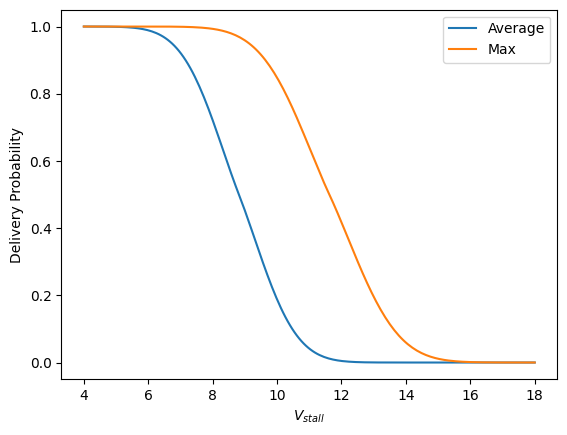

In [21]:
def norm_cdf(x, mu, sigma):
    z = (x - mu) / (sigma * np.sqrt(2))
    return 0.5 * (1 + erf_approx(z))


def erf_approx(z):
    # Abramowitz and Stegun formula 7.1.26 for erf(z) approximation
    t = 1 / (1 + 0.3275911 * np.abs(z))
    a1, a2, a3, a4, a5 = 0.254829592, -0.284496736, 1.421413741, -1.453152027, 1.061405429
    poly = (((a5 * t + a4) * t + a3) * t + a2) * t + a1
    erf_z = 1 - poly * np.exp(-z**2)
    return np.sign(z) * erf_z

v_stall_real = np.linspace(4, 18, 200)
v_stall_set = 1.05 * v_stall_real
v_min = 1.2 * v_stall_set
v_cruise = 1.2 * v_stall_set + 3
v_max = 1.5 * v_cruise

mu_max = 6.645098344016
sigma_max = 1.738169957638
mu_avg = 3.107432180653
sigma_avg = 1.450002302936

cdf_val_delivery_avg = 1 - norm_cdf(v_min - 8.0, mu_avg, sigma_avg)
cdf_val_delivery_max = 1 - norm_cdf(v_min - 8.0, mu_max, sigma_max)

plt.figure()
plt.plot(v_stall_real, cdf_val_delivery_avg)
plt.plot(v_stall_real, cdf_val_delivery_max)
plt.xlabel("$V_{stall}$")
plt.ylabel("Delivery Probability")
plt.legend(["Average", "Max"])
plt.show()

In [ ]:
print(sol(c_r)) # ok
print(sol(c_t)) # ok
print(sol(b/2)) # ok
print(sol(c_r_tail)) # ok
print(sol(c_t_tail)) # ok
print(sol(b_tail/2)) # ok
print(sol(x_tail)) # ok
print(sol(c_r_vt))
print(sol(c_t_vt))
print(sol(b_vt))
print(sol(-(c_r_vt - c_r_tail - offset_vt) + x_tail))

In [84]:
# Export to AVL file
avl = asb.aerodynamics.aero_3D.avl.AVL(
    airplane=sol(airplane_stability),
     op_point=asb.OperatingPoint(
        velocity=10,
        alpha=0,
    ),
)
avl.write_avl("CTOL_tail.avl")

In [15]:
print(sol(phi_turn))

1.1290888600479034
